# TP Bagging, Boosting, Random Forests  
  
Audrey Quessada, MDI 343-P2

## BAGGING  
  
Le *bagging* est un méta-algorithme qui combine plusieurs techniques de machine learning afin de diminuer la variance. Cette technique se décompose en 2 étapes: 

 * Produire une distribution de modèles entrainés sur des échantillons fabriqués à partir des observations. Les échantillons sont générés à partir des données de façon aléatoire, soit avec remise (bootstrap) soit sans remise.

 * Faire la moyenne des prédictions obtenues.


In [1]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
import matplotlib.pyplot as plt
import warnings
import random
from random import shuffle
warnings.filterwarnings('ignore')
%matplotlib inline

## Introduction

On va construire un prédicteur bagging en s'appuyant sur sa définition. On pourra comparer avec le prédicteur de $sklearn$. Dans un premier temps, on va définir une première fonction bootstrap qui permet de faire une tirage aléatoire d'observations d'un échantillon avec remise:

In [2]:
#k nombre de tirages à réaliser
def bootstrap(X,y,k):
    """Paramètres: 
    X,y : array
    les données à bootstrapper
    k: int
    la taille du bootstrap
    return:
    X_boot,y_boot: array
    les données bootstrappées
    """
    
    n_x = len(X)
    n_y = len(y)
    if n_x != n_y:
        print('les données doivent avoir la même dimension')
    else :
        n = n_x
    X_boot = []
    y_boot = []
    for i in range(k):
        d = random.randint(0,n-1)
        X_boot.append(X[d])
        y_boot.append(y[d])
    X_boot = np.array(X_boot)
    y_boot = np.array(y_boot)
    return X_boot,  y_boot   

On définit une fonction `rand_norem` qui permet d'effectuer parmi les données un tirage aléatoire sans remise:

In [3]:
def rand_norem(X,y,k):
    """Paramètres: 
    X,y : array
    les données initiales
    k: int
    la taille de l'échantillon sur lequel effectuer un tirage sans remise
    return:
    X_rand,y_rand: array
    les données après tirage sans remise
    """
    n_x = len(X)
    n_y = len(y)
    if n_x != n_y:
        print('les données doivent avoir la même dimension')
    else :
        n = n_x
    X_rand = []
    y_rand = []
    n1 = n
    for i in range(k):     
        n_temp = n1
        d = random.randint(0, n_temp-1)
        elx = X[d]
        ely = y[d]
        X_rand.append(elx)
        y_rand.append(ely)
        X = np.delete(X, d)
        y = np.delete(y, d)
        n1 = len(X)
        
    X_rand = np.array(X_rand).reshape(n,1)
    y_rand = np.array(y_rand).reshape(n,1)
    return X_rand, y_rand

On va tester ces deux fonctions sur un échantillon de données.  
Génération de l'échantillon (typiquement, on reprend celle de la suite du TP):

In [4]:
# Create a random dataset
rng = np.random.RandomState(1)
X_s = np.sort(5 * rng.rand(80, 1), axis=0)
y_s = np.sin(X_s).ravel()


In [5]:
n = len(X_s)
print(n)

80


Test de la fonction bootstrap:  

In [6]:
X_boot, y_boot = bootstrap(X_s,y_s,n)


Test de la fonction de tirage aléatoire d'observations d'un échantillon sans remise:

In [7]:
X_rand, y_rand = rand_norem(X_s,y_s,n)


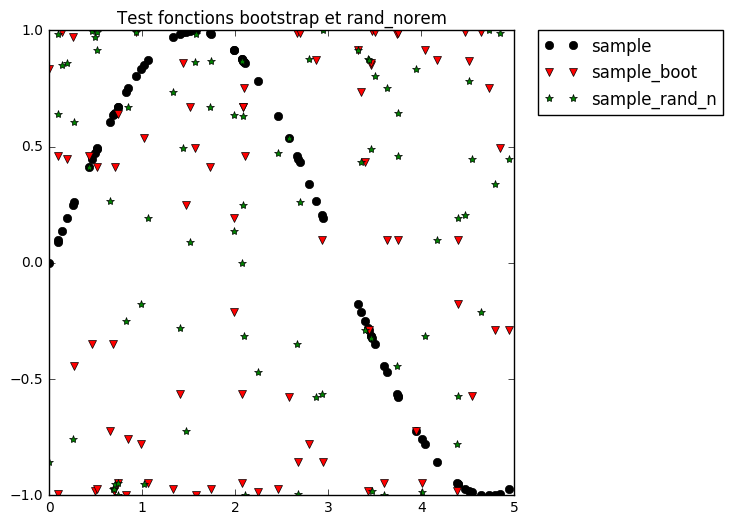

In [8]:
plt.figure(figsize=(6, 6))
plt.plot(X_s, y_s, 'o', c="k", label="sample")
plt.plot(X_s, y_boot, 'v', c="r", label="sample_boot")
plt.plot(X_s, y_rand, '*', c="g", label="sample_rand_n")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Test fonctions bootstrap et rand_norem')

In [9]:
y_randun = np.unique(y_rand)
y_bootun = np.unique(y_boot)
print(len(y_randun))
print(len(y_bootun))

80
47


Construction de la fonction de *bagging* qui va agréger les modèles issus de prédicteurs (la variable `classifier` dans ce cas):

In [10]:
def bagg(X, X_test, y, y_test, classifier, n_estimator, boot):
    """Paramètres: 
    X,y : array
    les données initiales d'entrainement du predicteur
    X_test,y_test : array
    les données de test 
    classifier: prédicteur qui va servir de support pour l'agrégation de modèle (sklearn)
    n_estimator: int
    le nombre d'estimateurs
    boot: boolean
    True pour le bootstrap
    False pour le tirage sans remise
    return:
    y_mean: array
    moyenne des y_pred prédits par les n_estimator classifier
    scores: le score du bagging sur la prédiction des données test
    les données après tirage sans remise
    """
    n = len(y)
    n_test = len(y_test)
    if boot == False:
        func = rand_norem
    else:
        func = bootstrap
    if n_estimator > 1:
        y_pred = np.zeros((n_test,n_estimator))      
        for i in range(n_estimator):
            X_temp, y_temp = func(X,y,n)
            classifier.fit(X_temp, y_temp)
            y_pred[:,i] = classifier.predict(X_test)       
        y_mean = (y_pred.sum(axis=1, dtype=np.float64))/n_estimator
        
    else:
        X_temp, y_temp = func(X,y,n)
        classifier.fit(X_temp, y_temp)
        y_mean = classifier.predict(X_test)
      
    num = ((y_test - y_mean) ** 2).sum(axis=0, dtype=np.float64)
    denom = ((y_test - np.average(y_test, axis=0)) ** 2).sum(axis=0, dtype=np.float64)
    scores = 1 - (num/denom)
    
    return y_mean, scores

### **Question 1 **   
Mettez en œuvre le Bagging avec des arbres de profondeur 1 (en Anglais stumps).  
Dans la plupart des questions, je vais utiliser la librairie sklearn pour les prédicteurs. Pour d'autres j'utiliserai les fonctions définies en introduction

In [11]:
# Create a random dataset
rng = np.random.RandomState(1)
X = np.sort(5 * rng.rand(80, 1), axis=0)
y = np.sin(X).ravel()

y[::5] += 1 * (0.5 - rng.rand(16))

L'échantillon étudié est les points d'un fonction sinus à laquelle on a rajouté du bruit (tous les 5 points).

In [12]:
n_estimators = 10 # L in the text
tree_max_depth = 10
bagging_max_depth = 10
seed = 42

In [13]:
# Define the regressor by bagging stumps (sklearn)
tree = DecisionTreeRegressor(max_depth=1, random_state=seed) 
tree.fit(X, y)


DecisionTreeRegressor(criterion='mse', max_depth=1, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=42,
           splitter='best')

In [14]:
# bagging = BaggingRegressor de sklearn
bagging_skl = BaggingRegressor(base_estimator=tree,n_estimators=n_estimators, bootstrap=True, n_jobs=4, random_state=seed)
bagging_skl.fit(X, y)

BaggingRegressor(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=1, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=42,
           splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=10, n_jobs=4, oob_score=False,
         random_state=42, verbose=0, warm_start=False)

In [15]:
# Predict
X_test = np.arange(0.0, 5.0, 0.01)[:, np.newaxis]

y_test = np.sin(X_test).ravel()
y_tree = tree.predict(X_test)
y_bagging_skl = bagging_skl.predict(X_test)
print(len(X_test))


500


J'utilise également ma fonction pour pouvoir comparer:

In [16]:
y_bag_hm,score_bag_hm = bagg(X, X_test, y, y_test, tree, n_estimators, True)

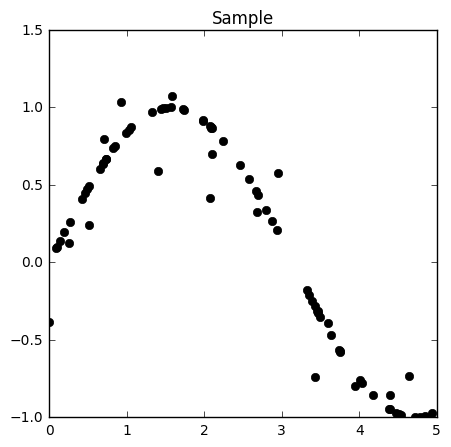

In [17]:
# Plot the results
plt.figure(figsize=(5, 5))
plt.plot(X, y, 'o', c="k", label="data")
plt.title('Sample')

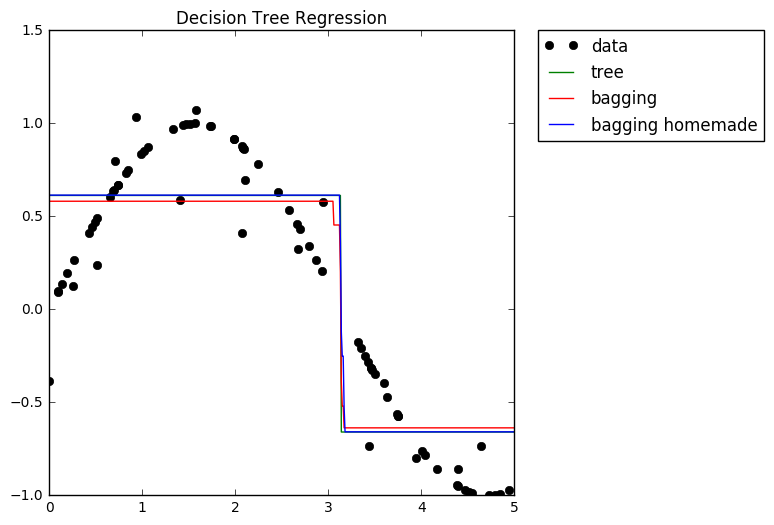

In [18]:
# add plots for Bagging/Tree
plt.figure(figsize=(6, 6))
plt.title("Decision Tree Regression")
plt.plot(X, y, 'o', c="k", label="data")
plt.plot(X_test, y_tree, c="g", label="tree")
plt.plot(X_test, y_bagging_skl, c="r", label="bagging")
plt.plot(X_test, y_bag_hm, c="b", label="bagging homemade")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

### **Question 2**  
On va illustrer graphiquement le rôle de $L$ ainsi que de la profondeur des arbres (`max_depth`).  
Dans un premier temps, on s'intéresse à la profondeur de l'arbre. On utilise donc des arbres de profondeur de 1 à 10:

score de l'arbre de décision:  [0.80944735232337417, 0.90249965974850277, 0.96314249236854366, 0.96106151058228551, 0.96767746937720045, 0.96410730481513696, 0.96204810767875815, 0.96153412521477644, 0.96142607801717139, 0.96150692707406882]
____________________
score du bagging sklearn:  [0.81157040982462136, 0.91879001834626983, 0.9703856340018967, 0.98160495093205558, 0.98370242985318512, 0.98499131927898342, 0.98465906598681641, 0.98383666106956247, 0.98380916756957415, 0.98381269102620406]
____________________
score du bagging homemade:  [0.81990764486176981, 0.91169803843065744, 0.97392022842579518, 0.98475443242471106, 0.98424138709677655, 0.98082697102335781, 0.97941349580111703, 0.98474948524326089, 0.98433190041979723, 0.97406896997247705]


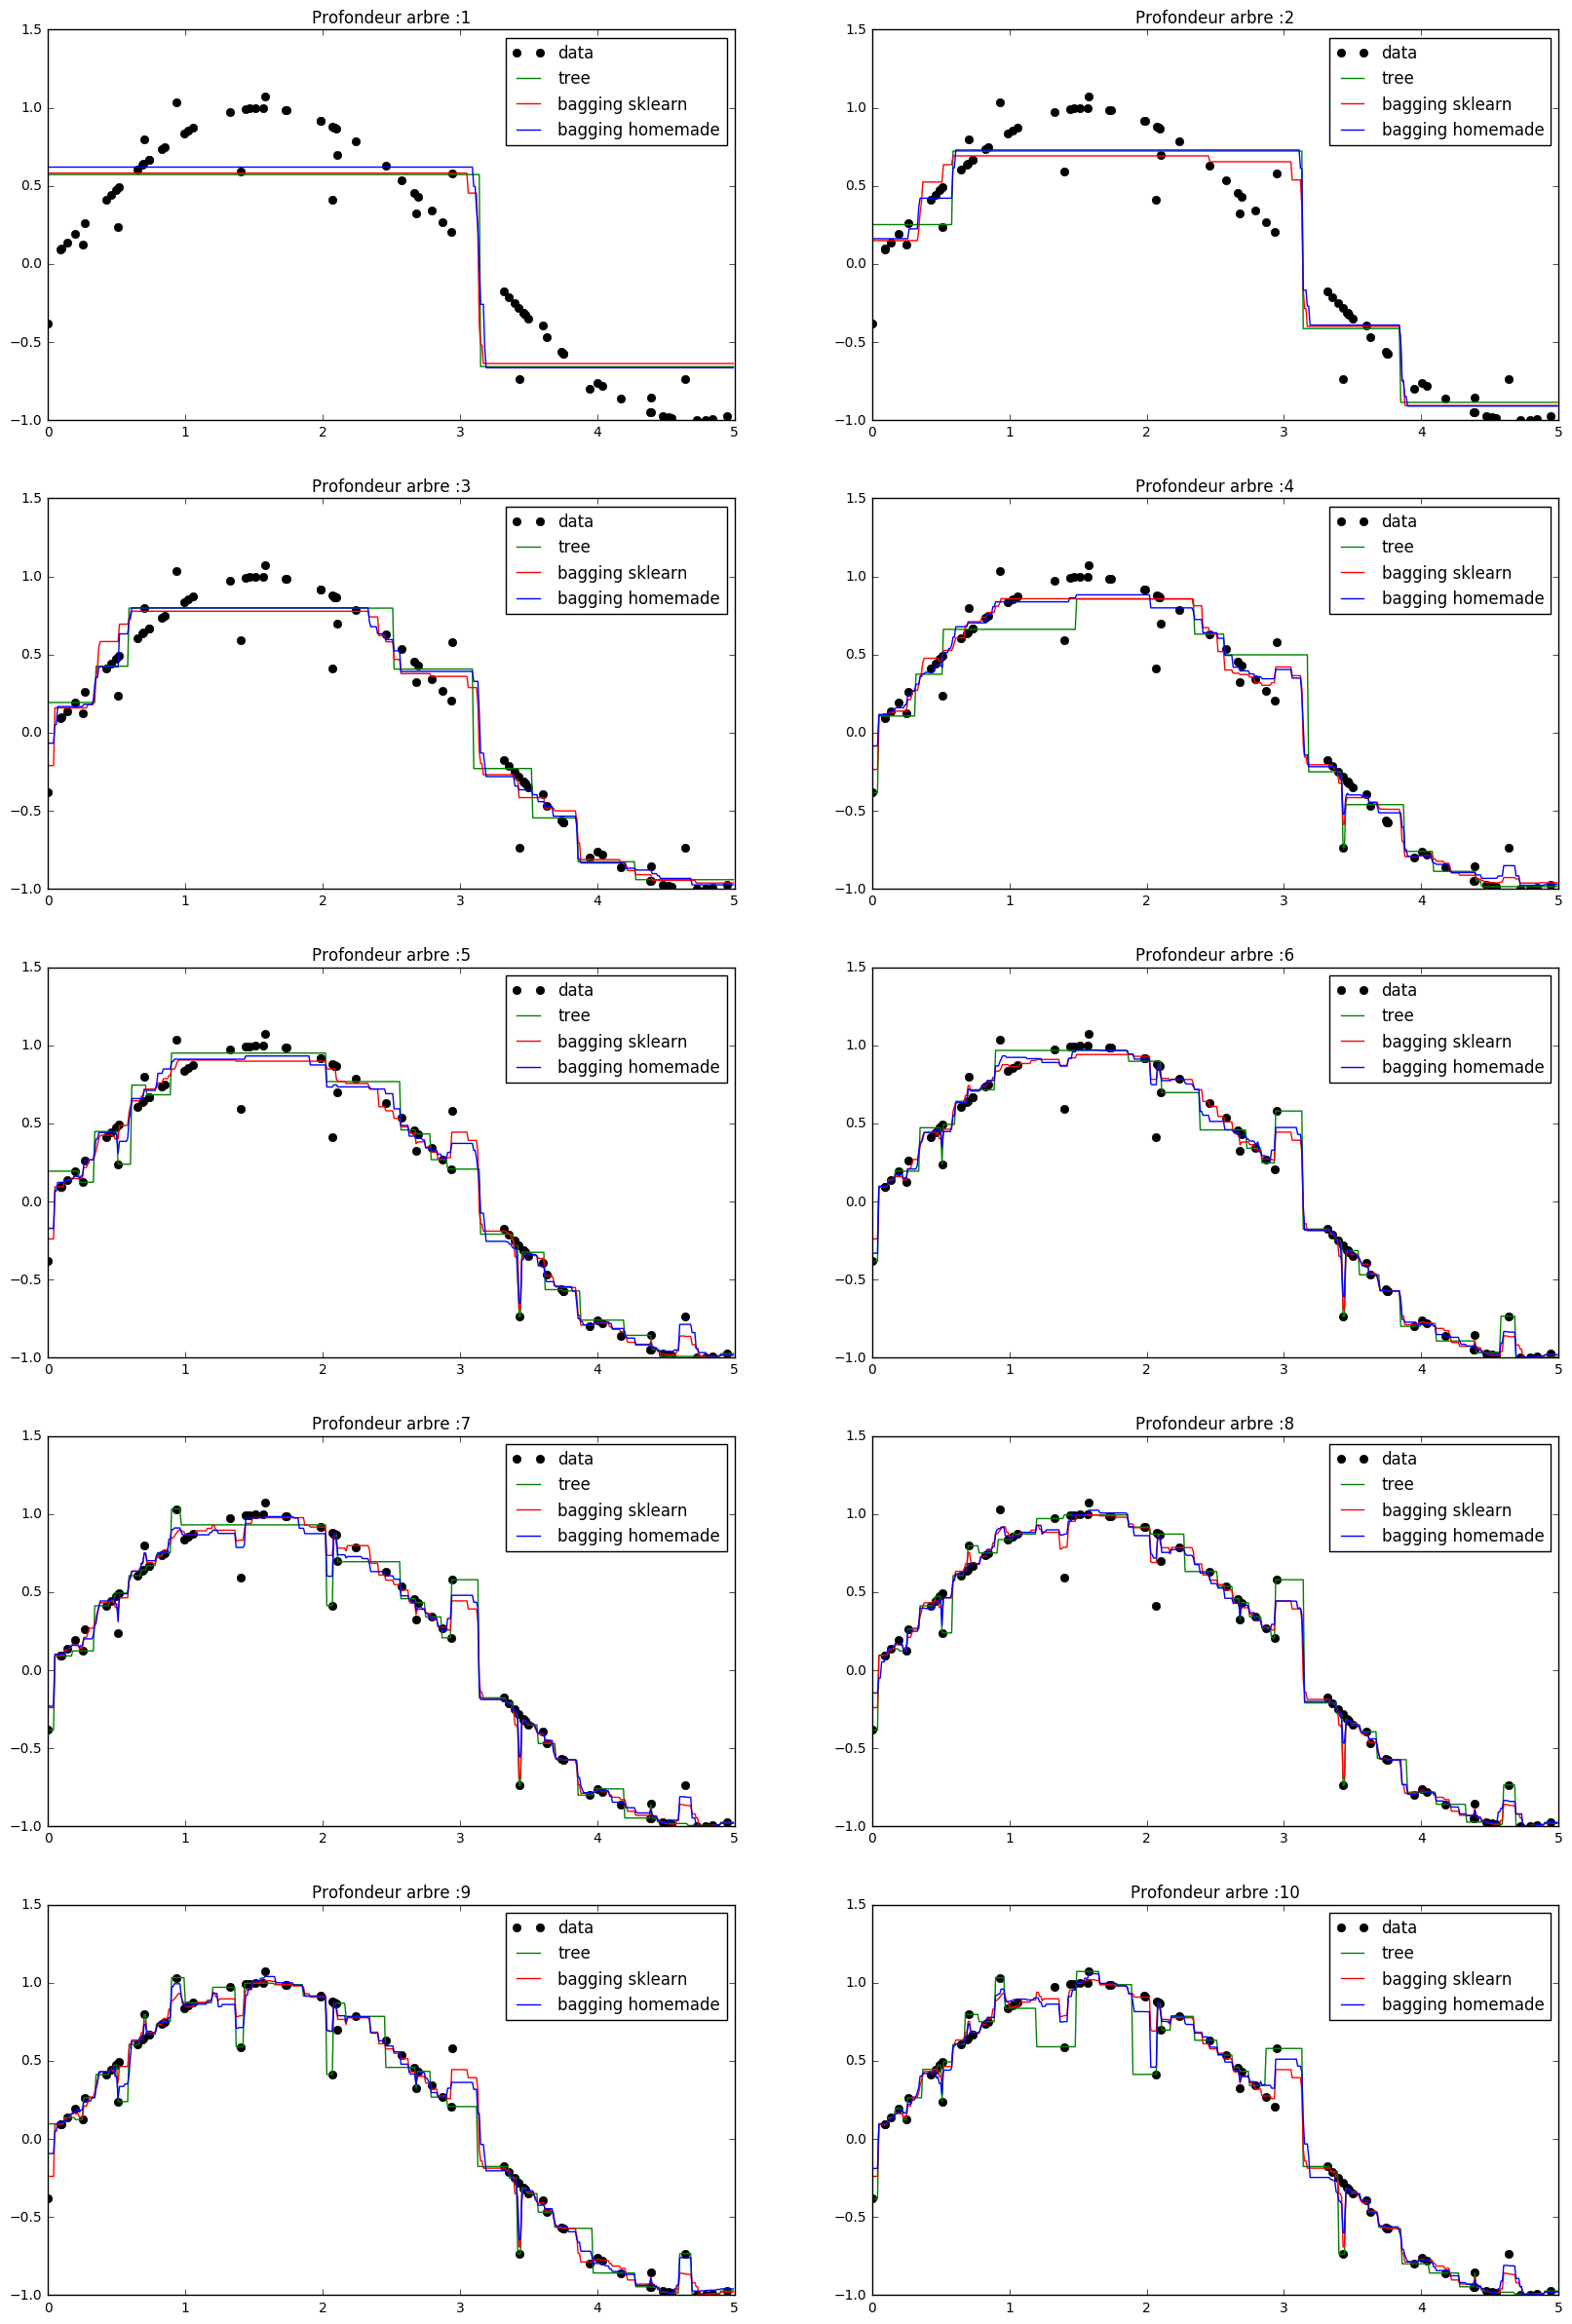

In [19]:
y_tree = np.zeros((500,11))
y_bagging = np.zeros((500,11))
y_bagging_hm = np.zeros((500,11))
score_tree_d = []
score_bagging_d = []
score_bagging_dhm = []

fig = plt.figure(figsize=(20, 30))

for i in range(1,tree_max_depth+1):
    tree = DecisionTreeRegressor(max_depth=i, random_state=seed)
    tree.fit(X, y) 
    score_tree_d.append(tree.score(X_test,y_test))
    bagging_skl = BaggingRegressor(base_estimator=tree,n_estimators=n_estimators, bootstrap=True, n_jobs=4, random_state=seed)
    bagging_skl.fit(X, y)
    score_bagging_d.append(bagging_skl.score(X_test,y_test))
    y_bagging_hm[:,i], sc = bagg(X, X_test, y, y_test, tree, n_estimators, True)
    score_bagging_dhm.append(sc)
    
    y_tree[:,i]= tree.predict(X_test)
    y_bagging[:,i]= bagging_skl.predict(X_test)
    plt.subplot(5, 2, i)
    g1 = plt.plot(X, y, 'o', c="k", label="data")
    g2 = plt.plot(X_test, y_tree[:,i], c="g", label="tree")
    g3 = plt.plot(X_test, y_bagging[:,i], c="r", label="bagging sklearn")
    g4 = plt.plot(X_test, y_bagging_hm[:,i], c="b", label="bagging homemade")
    plt.legend()
    plt.title('Profondeur arbre :'+str(i))
    
print('score de l\'arbre de décision: ', score_tree_d)
print('____________________')
print('score du bagging sklearn: ', score_bagging_d)
print('____________________')
print('score du bagging homemade: ', score_bagging_dhm)

On remarque clairement que la profondeur de l'arbre améliore la prédiction. Si on trace les scores pour chaque régresseur en fonction de l'arbre, voilà ce qu'on obtient:

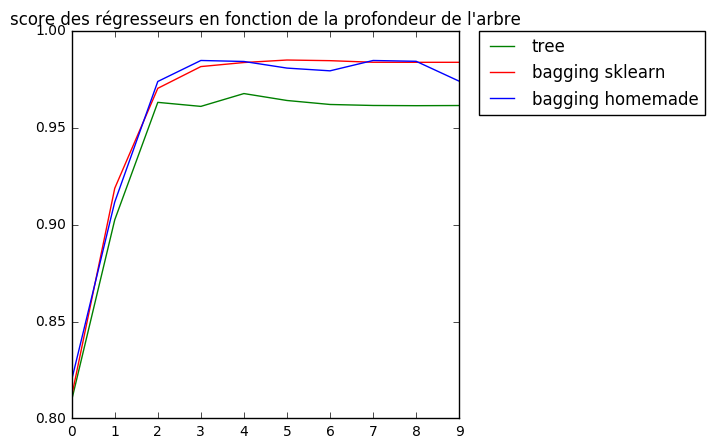

In [20]:
fig = plt.figure(figsize=(5,5))
x_depth = np.arange(0.0, 10.0, 1.0)
plt.plot(x_depth,score_tree_d, "g", label="tree")
plt.plot(x_depth,score_bagging_d, "r", label="bagging sklearn")
plt.plot(x_depth,score_bagging_dhm, "b", label="bagging homemade")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('score des régresseurs en fonction de la profondeur de l\'arbre')

On s'intéresse maintenant aux nombres d'estimateurs. Pour une profondeur donnée (ici on teste 1 et 10 respectivement), on varie le nombre d'estimateurs.

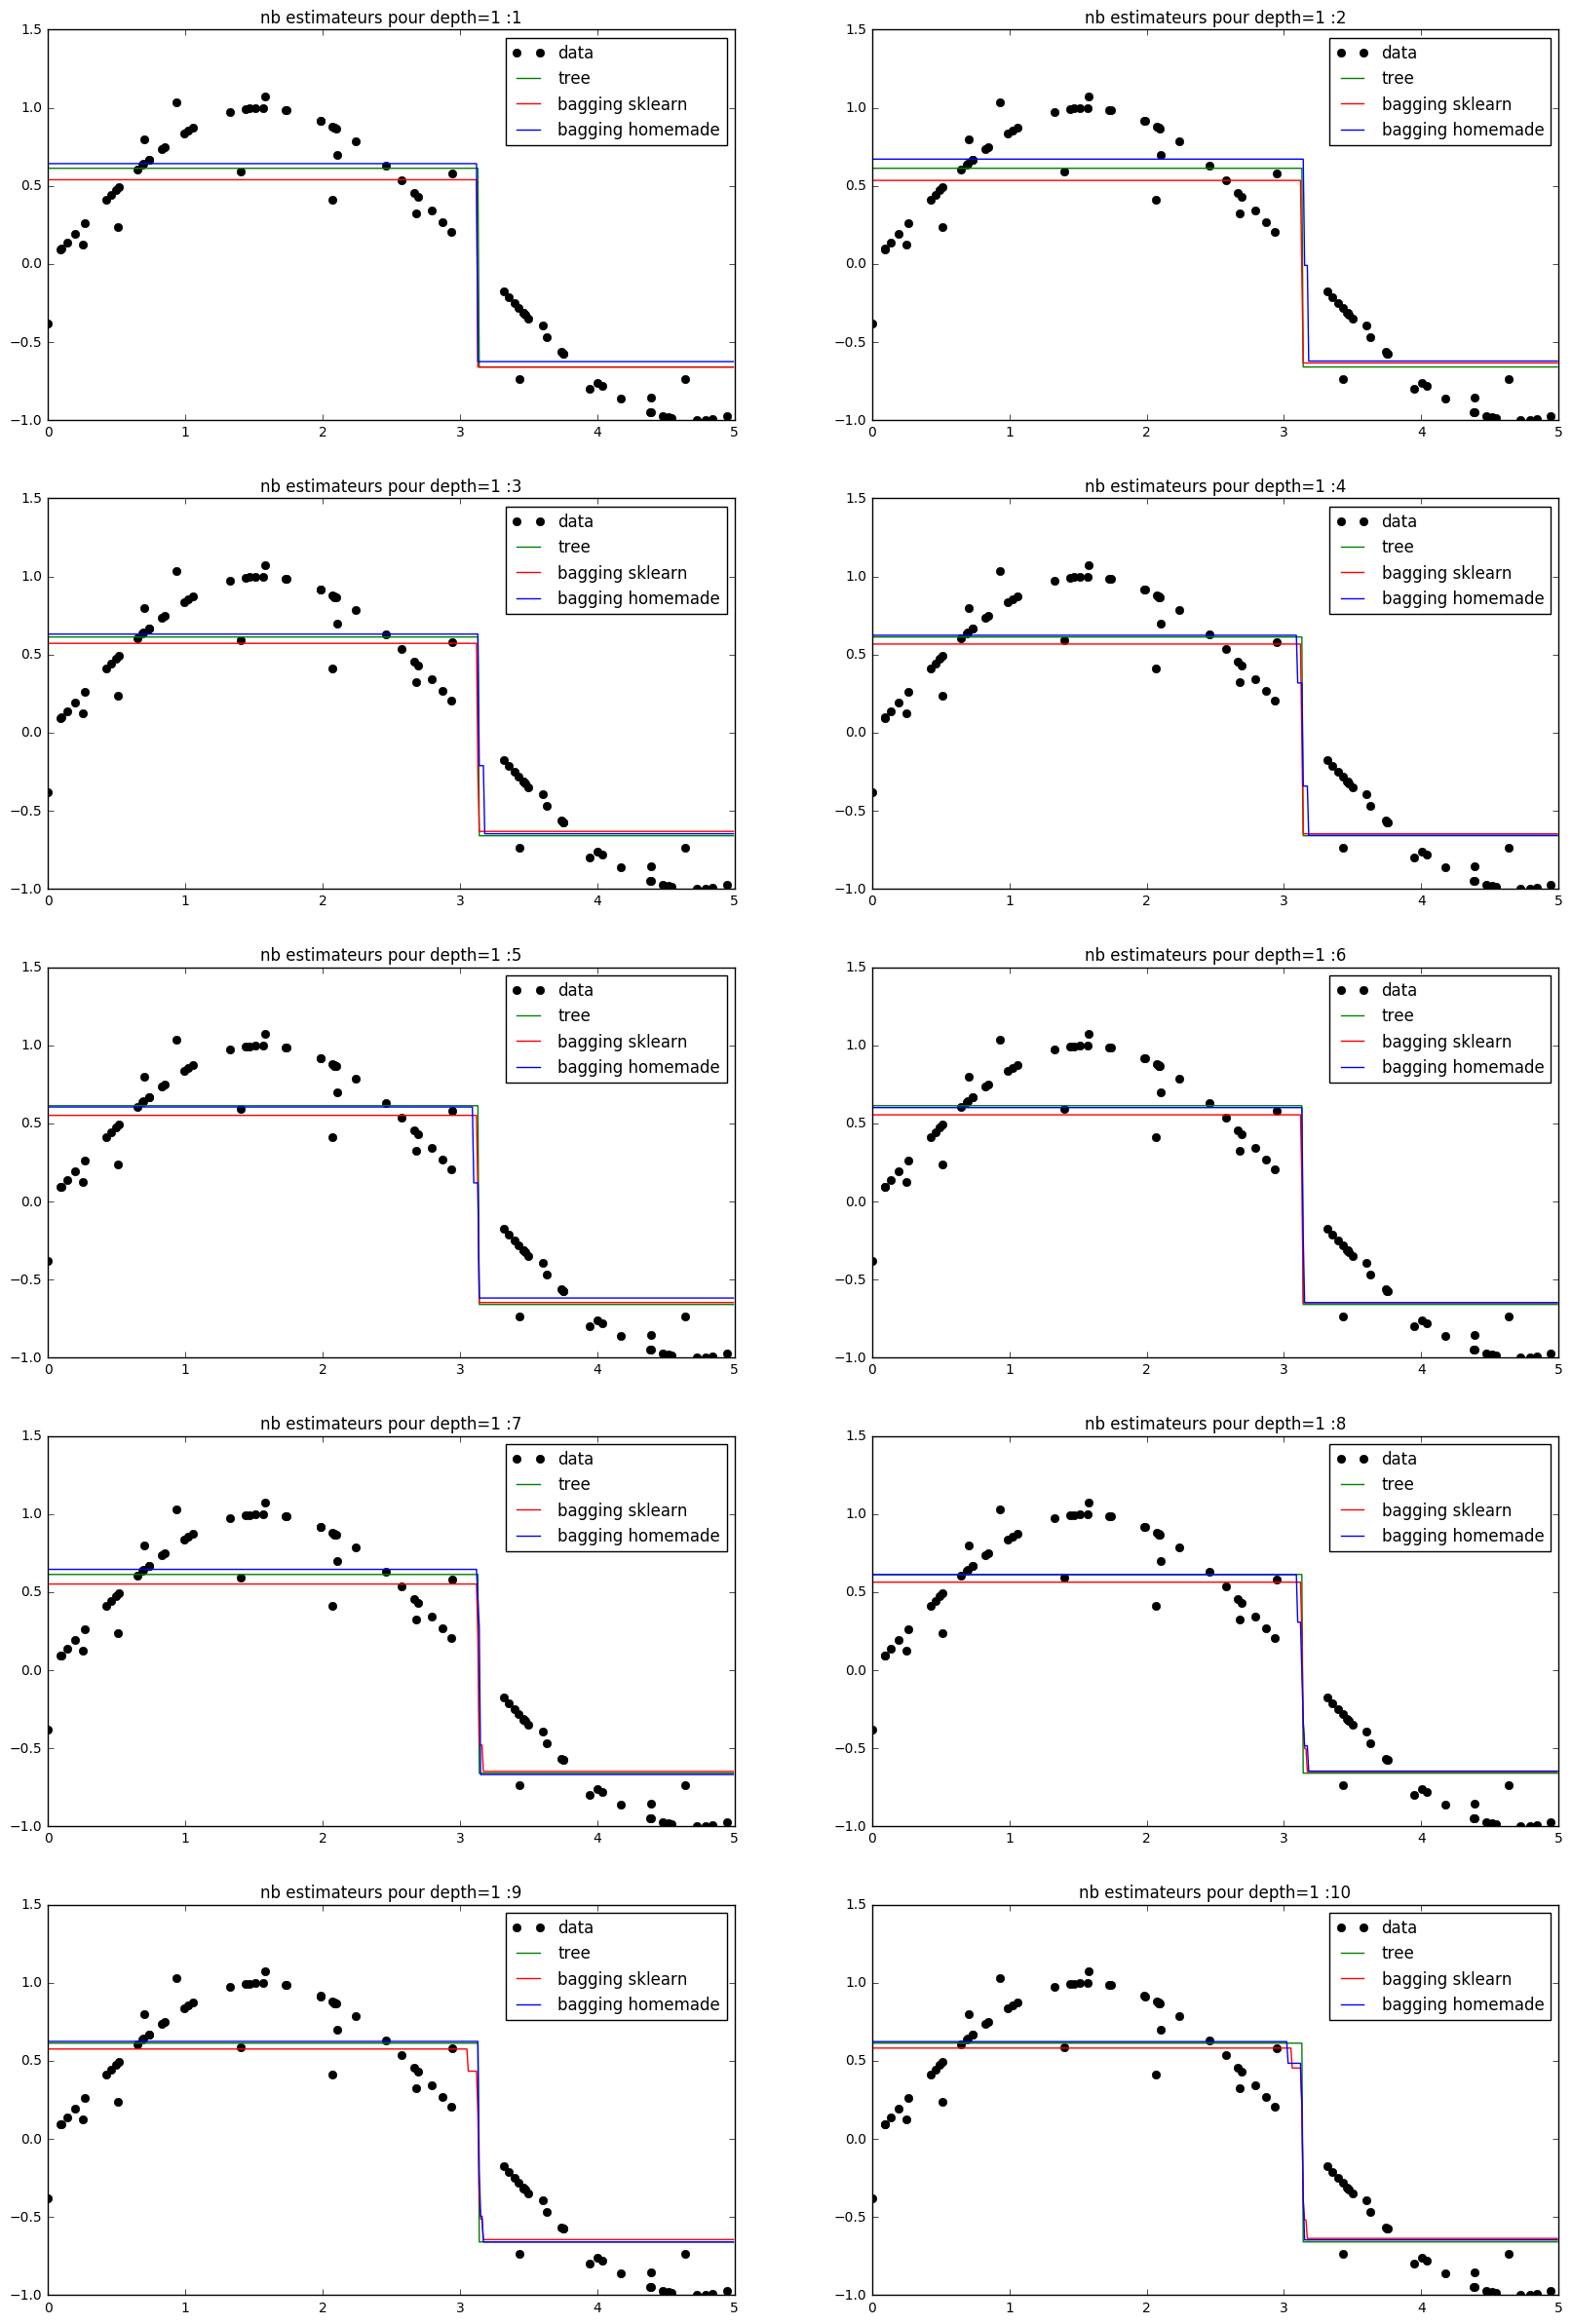

In [21]:
y_tree_l = np.zeros((500,11))
y_bagging_l = np.zeros((500,11))
y_bagging_lhm = np.zeros((500,11))

fig = plt.figure(figsize=(20, 30))
for i in range(1, n_estimators+1):
    tree = DecisionTreeRegressor(max_depth=1, random_state=seed)
    tree.fit(X, y)
    bagging_skl = BaggingRegressor(base_estimator=tree, n_estimators=i, bootstrap=True, n_jobs=4, random_state=seed)
    bagging_skl.fit(X, y)
    y_tree_l[:,i]= tree.predict(X_test)
    y_bagging_l[:,i]= bagging_skl.predict(X_test)
    y_bagging_lhm[:,i], sc = bagg(X, X_test, y, y_test, tree, i, True)
    
    plt.subplot(5, 2, i)
    plt.plot(X, y, 'o', c="k", label="data")
    plt.plot(X_test, y_tree_l[:,i], c="g", label="tree")
    plt.plot(X_test, y_bagging_l[:,i], c="r", label="bagging sklearn")
    plt.plot(X_test, y_bagging_lhm[:,i], c="b", label="bagging homemade")
    plt.legend()
    plt.title('nb estimateurs pour depth=1 :'+str(i))
    

score de l'arbre de décision:  [0.96150692707406882, 0.96150692707406882, 0.96150692707406882, 0.96150692707406882, 0.96150692707406882, 0.96150692707406882, 0.96150692707406882, 0.96150692707406882, 0.96150692707406882, 0.96150692707406882]
____________________
score du bagging sklearn:  [0.9884935546340935, 0.98165809429258444, 0.9869620658969156, 0.98506682400710099, 0.98205027936367961, 0.98112951066444287, 0.9826562795445416, 0.98125543035472496, 0.98338330153644771, 0.98381269102620406]
____________________
score du bagging homemade:  [0.97982534518673015, 0.98089894680026457, 0.9674331107284474, 0.97652184230027994, 0.97956767744829421, 0.98126561408132984, 0.98569218281135296, 0.97983787106171871, 0.98096595094268579, 0.97559796147061983]


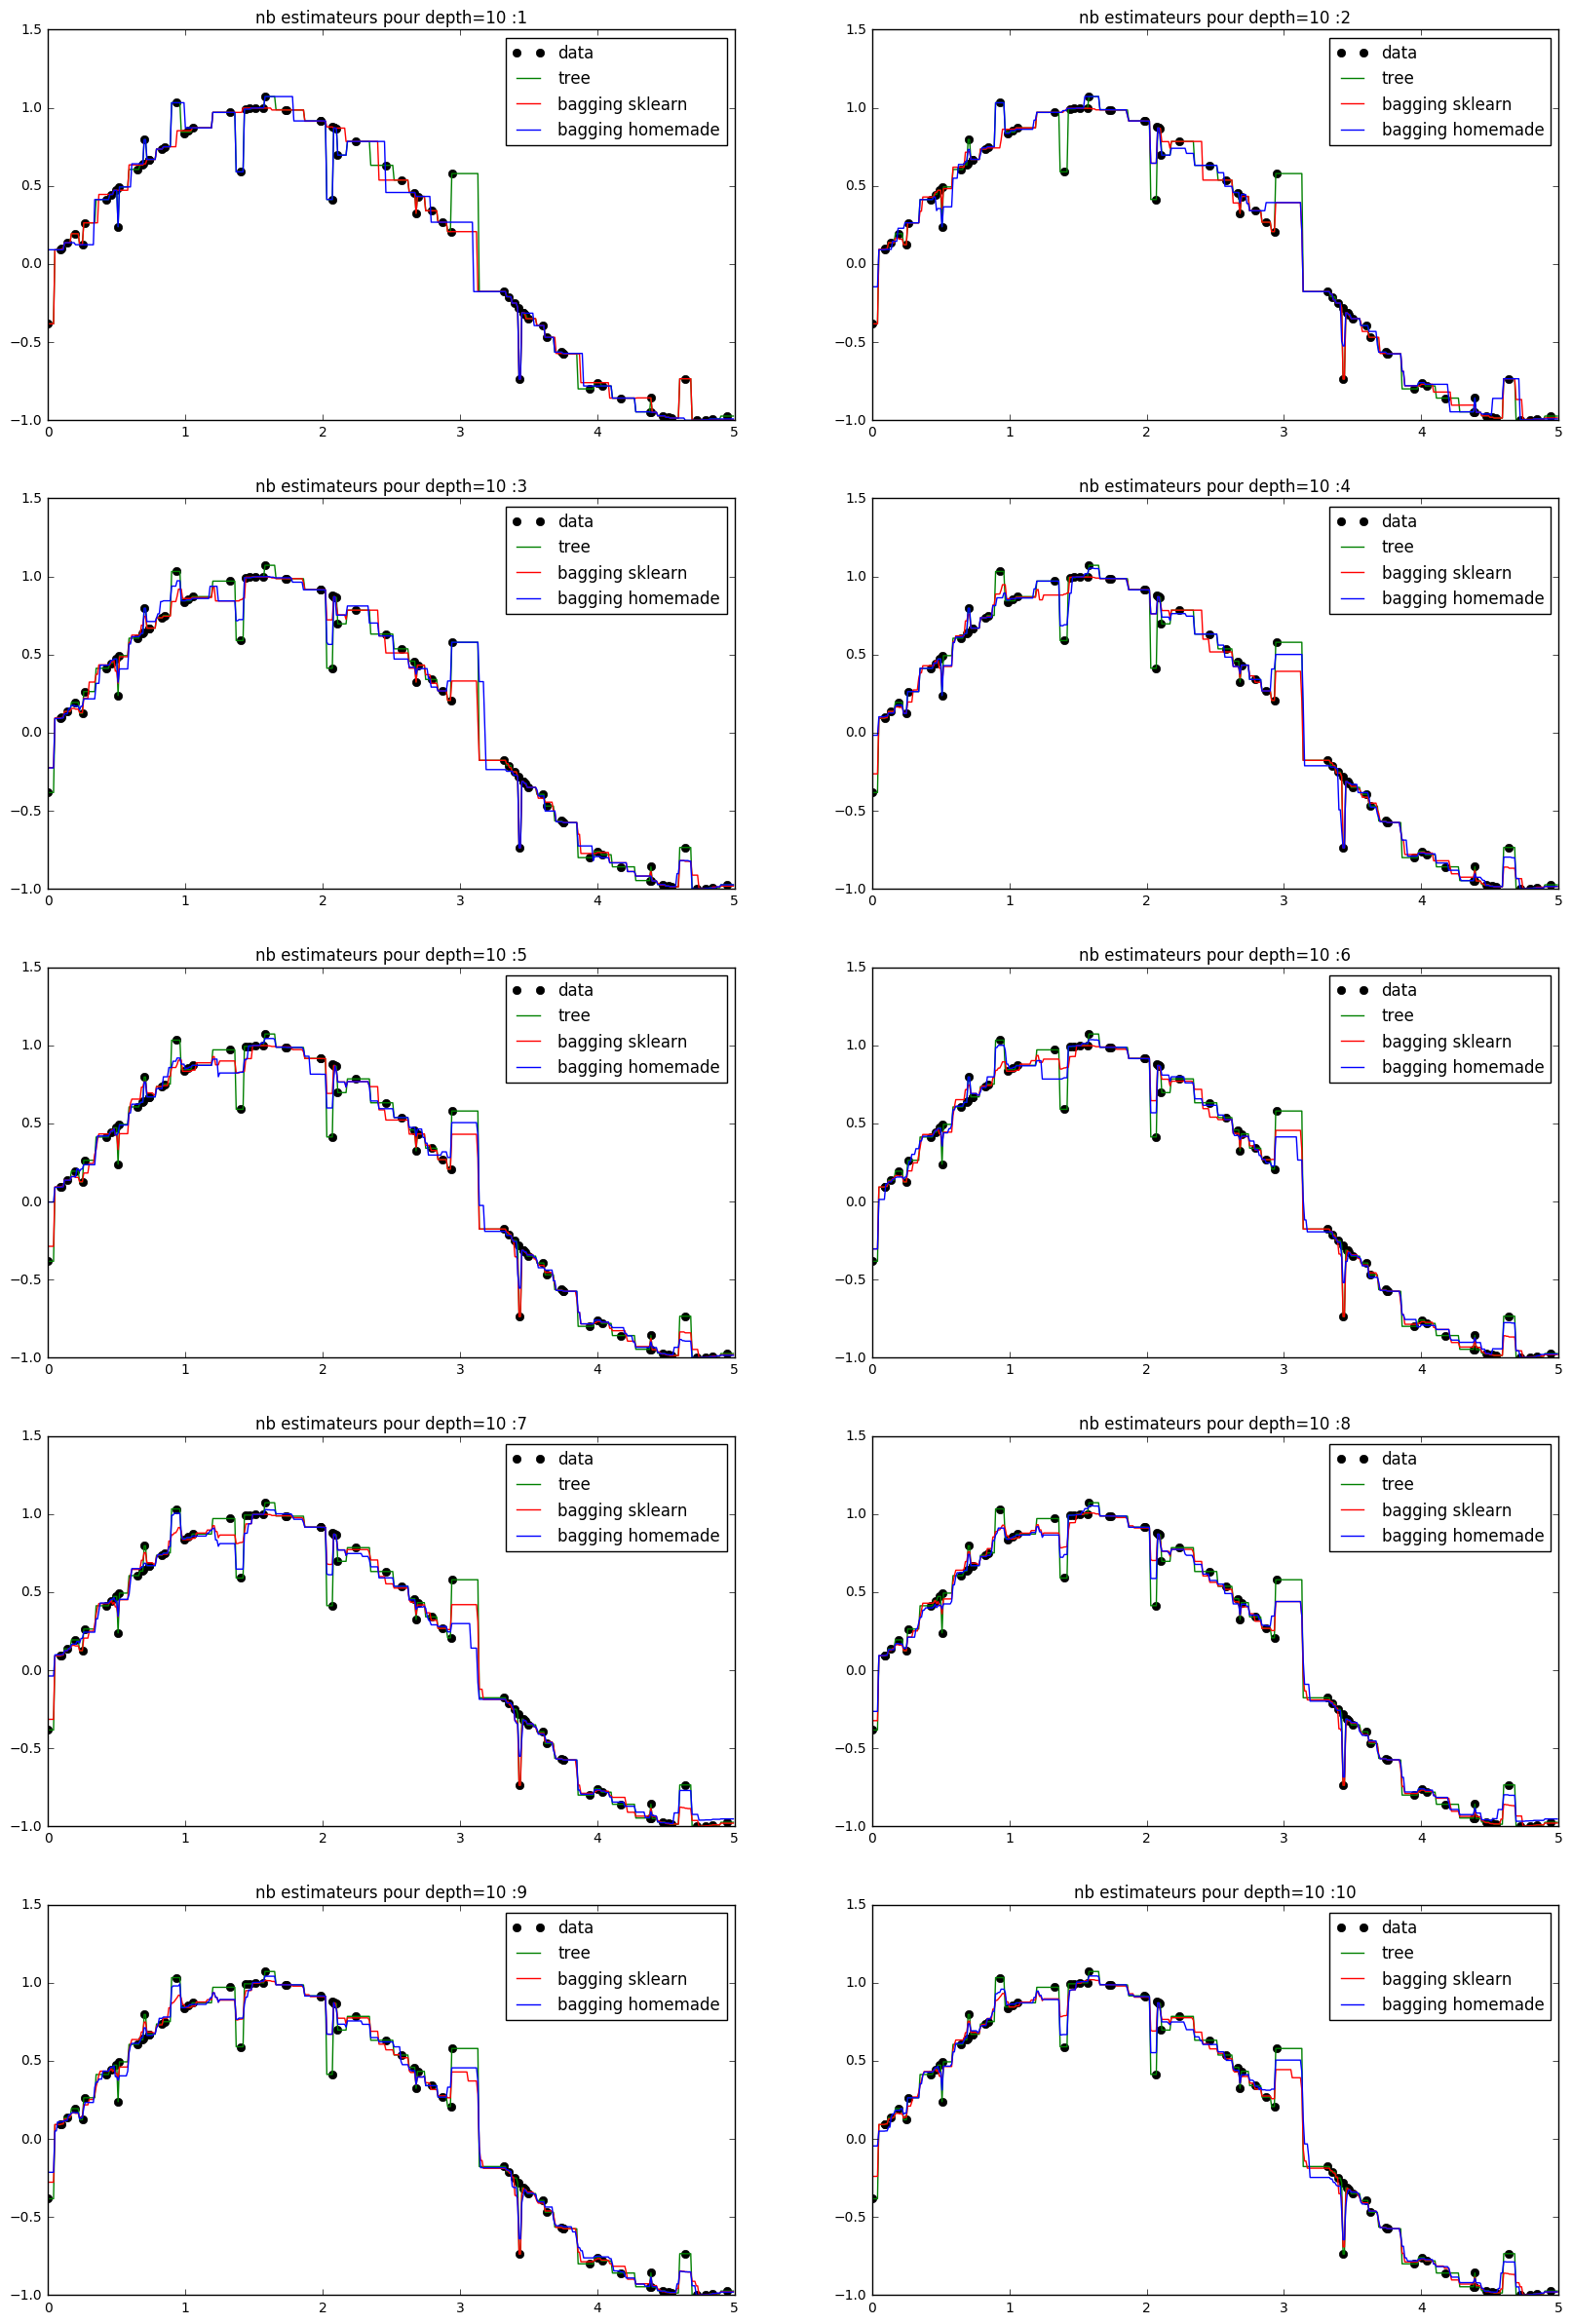

In [22]:
y_tree_l = np.zeros((500,11))
y_bagging_l = np.zeros((500,11))
y_bagging_lhm = np.zeros((500,11))
score_tree_l = []
score_bagging_l = []
score_bagging_lhm = []

fig = plt.figure(figsize=(20, 30))
for i in range(1, n_estimators+1):
    tree = DecisionTreeRegressor(max_depth=10, random_state=seed)
    tree.fit(X, y)
    score_tree_l.append(tree.score(X_test,y_test))
    bagging_skl = BaggingRegressor(base_estimator=tree, n_estimators=i, bootstrap=True, n_jobs=4, random_state=seed)
    bagging_skl.fit(X, y)
    score_bagging_l.append(bagging_skl.score(X_test,y_test))
    y_tree_l[:,i]= tree.predict(X_test)
    y_bagging_l[:,i]= bagging_skl.predict(X_test)
    y_bagging_lhm[:,i], sc = bagg(X, X_test, y, y_test, tree, i, True)
    score_bagging_lhm.append(sc)
    
    plt.subplot(5, 2, i)
    plt.plot(X, y, 'o', c="k", label="data")
    plt.plot(X_test, y_tree_l[:,i], c="g", label="tree")
    plt.plot(X_test, y_bagging_l[:,i], c="r", label="bagging sklearn")
    plt.plot(X_test, y_bagging_lhm[:,i], c="b", label="bagging homemade")
    plt.legend()
    plt.title('nb estimateurs pour depth=10 :'+str(i))
print('score de l\'arbre de décision: ',score_tree_l)
print('____________________')
print('score du bagging sklearn: ',score_bagging_l)  
print('____________________')
print('score du bagging homemade: ',score_bagging_lhm) 

On s'intéresse au score obtenu pour $L$ et nb_estimator qui varient 

In [23]:
score_baggingskl_tot = []
score_bagginghm_tot = []
for i in range(1,tree_max_depth+1):
    score_tempskl = []
    score_temphm = []
    tree = DecisionTreeRegressor(max_depth=i, random_state=seed)
    for j in range(1,n_estimators+1):
        bagging_skl= BaggingRegressor(base_estimator=tree,n_estimators=j, bootstrap=True, n_jobs=4, random_state=seed)
        bagging_skl.fit(X, y)
        score_tempskl.append(bagging_skl.score(X_test,y_test))
        _, sc = bagg(X, X_test, y, y_test, tree, j, True)
        score_temphm.append(sc)
    score_baggingskl_tot.append(score_tempskl)
    score_bagginghm_tot.append(score_temphm)
score_baggingskl_tot = np.array(score_baggingskl_tot).reshape(10,10)
score_bagginghm_tot = np.array(score_bagginghm_tot).reshape(10,10)

In [24]:
import seaborn as sns

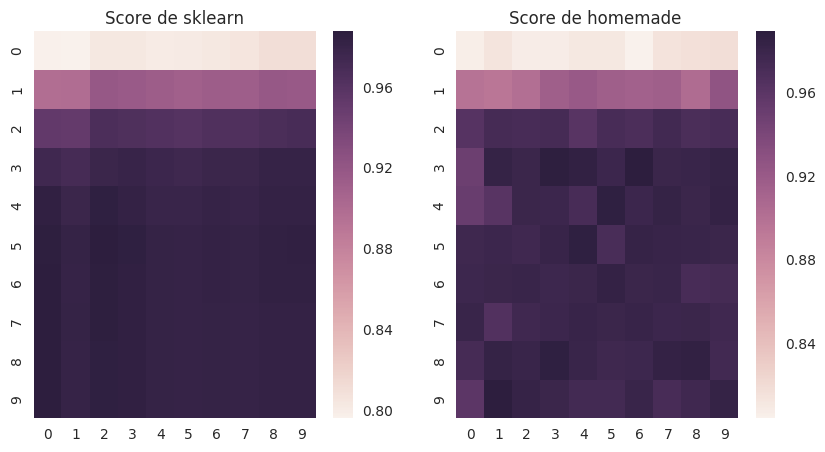

In [25]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(121)
sns.heatmap(score_baggingskl_tot)
plt.title('Score de sklearn')
ax2 = fig.add_subplot(122)
sns.heatmap(score_bagginghm_tot)
plt.title('Score de homemade ')

Pour chaque profondeur d'arbre, on trace pour les deux estimateurs le score en fonction du nombre d'estimateurs.

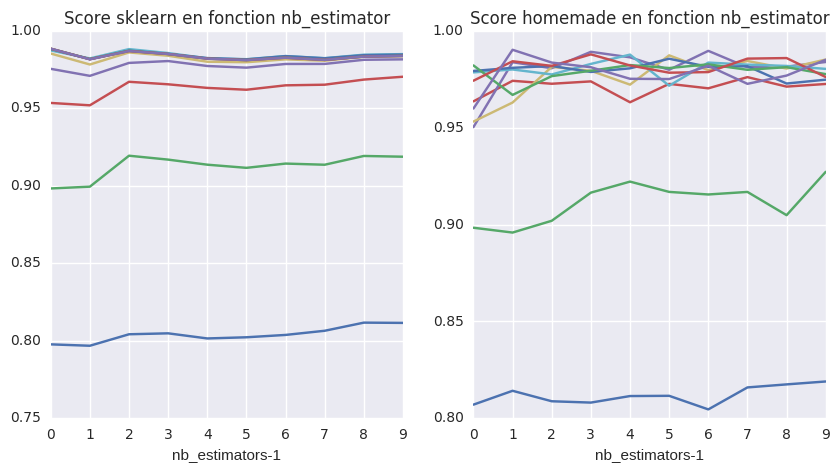

In [26]:
fig = plt.figure(figsize=(10, 5))
x_score = np.arange(0.0, 10.0, 1.0)
ax1 = fig.add_subplot(121)
for i in range(tree_max_depth):
    plt.plot(x_score, score_baggingskl_tot[i,:])
    ax1.set_xlabel('nb_estimators-1')
    plt.title('Score sklearn en fonction nb_estimator')
ax2 = fig.add_subplot(122)
for i in range(tree_max_depth):
    plt.plot(x_score, score_bagginghm_tot[i,:])
    ax2.set_xlabel('nb_estimators-1')
    plt.title('Score homemade en fonction nb_estimator')
              

## **Question 3**  
En regression le risque d'un estimateur se décompose suivant le biais, la variance et le bruit. La variance donnant une idée de la variabilité des prédictions d'un estimateur sur différentes instances du problème, celle- ci est large dans le cas d'un arbre de décision car une petite variation dans l'ensemble d'apprentissage va engendrer un arbre complètement différent.  
En revanche, avec le bagging, on agrège les arbres et donc on réduit la sensibilité aux variations. De fait, la variance est plus petite.


## **Question 4:**  
En jouant sur le niveau de bruit mettez en évidence le sur-apprentissage.  
On choisit profondeur d'arbre=10 et $L$ = 10

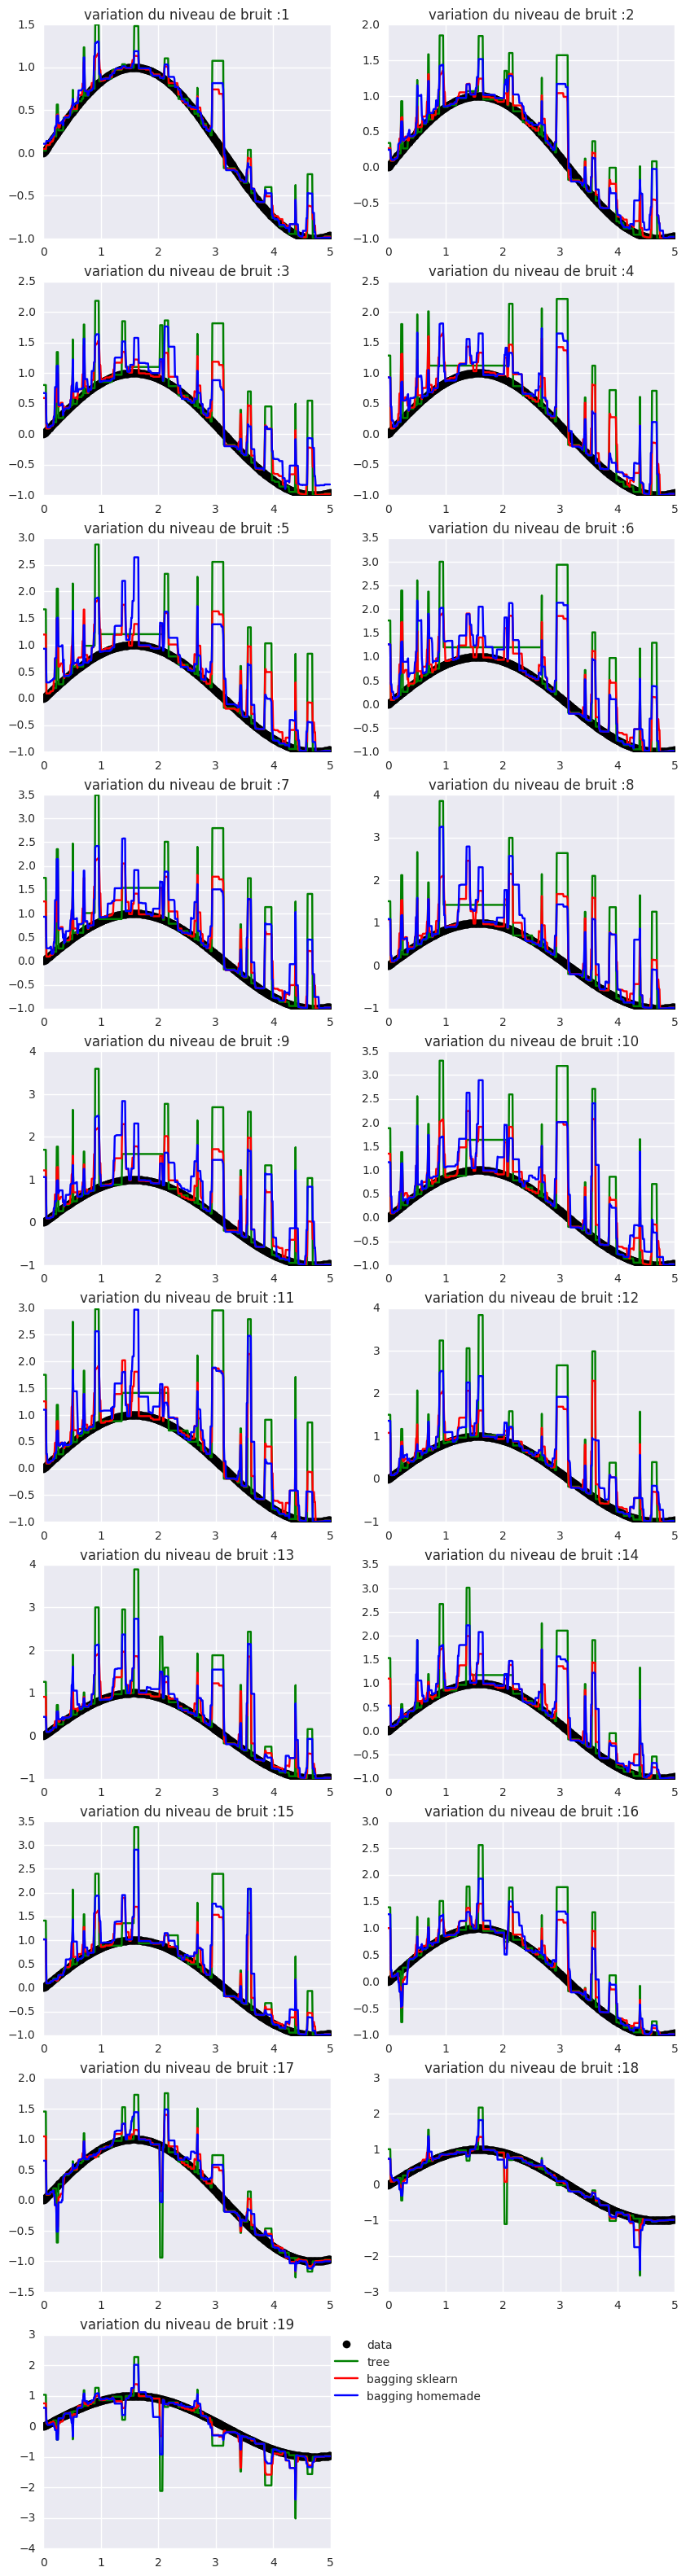

In [27]:
tree = DecisionTreeRegressor(max_depth=10, random_state=seed)
bagging_skl = BaggingRegressor(base_estimator=tree,n_estimators=10, bootstrap=True, n_jobs=4, random_state=seed)

fig = plt.figure(figsize=(10, 40))
for i in range(1,20):
    y[::5] += 1.0 * (0.5 - (i/10.0)*rng.rand(16))
    tree.fit(X, y)
    bagging_skl.fit(X, y)
    y_tree_pred = tree.predict(X_test)
    y_baggingskl_pred = bagging_skl.predict(X_test)
    y_bagginghm_pred, sc = bagg(X, X_test, y, y_test, tree, 10, True)
    plt.subplot(10, 2, i)
    plt.plot(X_test, y_test, 'o', c="k", label="data")
    plt.plot(X_test, y_tree_pred, c="g", label="tree")
    plt.plot(X_test, y_baggingskl_pred, c="r", label="bagging sklearn")
    plt.plot(X_test, y_bagginghm_pred, c="b", label="bagging homemade")
    plt.title('variation du niveau de bruit :'+str(i))
plt.legend(bbox_to_anchor=(1.0, 1.0), loc=2, borderaxespad=0.)    

Avec les graphes obtenus, on voit clairement que le bruit est très bien fitté que ce soit par le decision tree que par les baggings, et ce, même si le bruit augmente. Par conséquent, il y a sur-apprentissage.

# **Qestion 5:**    
Observer qu’on peut réduire ce phénomène en sous-échantillonnant aléatoirement (sans remise) au
lieu de prendre des échantillons bootstrap.  
Dans notre cas, pour fixer les idées, on va prendre un niveau de bruit correspondant à $i=15$. On va par la même occasion tester l'estimateur bagging de $sklearn$ avec l'option **False** et notre fonction  bagging avec la même option.

In [28]:
#génération de l'échantillon à entrainer
rng = np.random.RandomState(1)
X = np.sort(5 * rng.rand(80, 1), axis=0)
y = np.sin(X).ravel()
#ajout de bruit
y[::5] += 1 * (0.5 - 1.5*rng.rand(16))

#géneration de l'échantillon à tester
X_test = np.arange(0.0, 5.0, 0.01)[:, np.newaxis]
y_test = np.sin(X_test).ravel()

#implémentation des régresseurs à partir de la librairie sklearn
tree = DecisionTreeRegressor(max_depth=10, random_state=seed)
bagskl_true = BaggingRegressor(base_estimator=tree,n_estimators=10, bootstrap=True, n_jobs=4, random_state=seed)
bagskl_false = BaggingRegressor(base_estimator=tree,n_estimators=10, bootstrap=False, n_jobs=4, random_state=seed)

#entrainement du bagging sklearn 
bagskl_true.fit(X, y)
bagskl_false.fit(X, y)
#prédiction avec le bagging skleanr
y_bagskl_true = bagskl_true.predict(X_test)
score_skl_true = bagskl_true.score(X_test,y_test)
score_skl_false = bagskl_false.score(X_test,y_test)
y_bagskl_false = bagskl_false.predict(X_test)
y_baghm_true, sct = bagg(X, X_test, y, y_test, tree, 10, True)
y_baghm_false, scf = bagg(X, X_test, y, y_test, tree, 10, False)


In [29]:
print('le score obtenu par bagging sklearn boot=True :', score_skl_true)
print('le score obtenu par bagging sklearn boot=False :', score_skl_false)
print('le score obtenu par bagging homemade boot=True :', sct)
print('le score obtenu par bagging homemade boot=False :', scf)

le score obtenu par bagging sklearn boot=True : 0.960199384439
le score obtenu par bagging sklearn boot=False : 0.907980118556
le score obtenu par bagging homemade boot=True : 0.949185337431
le score obtenu par bagging homemade boot=False : 0.907980118556


Dans les 2 cas "False" (bagging $sklearn$ et bagging homemade) le score obtenu est inférieur à celui obtenu dans les cas "True", ce qui signifie que la prédiction est moins bonne.

Test de la fonction bagging en la comparant avec les résultats obtenus par le prédicteur de sklearn

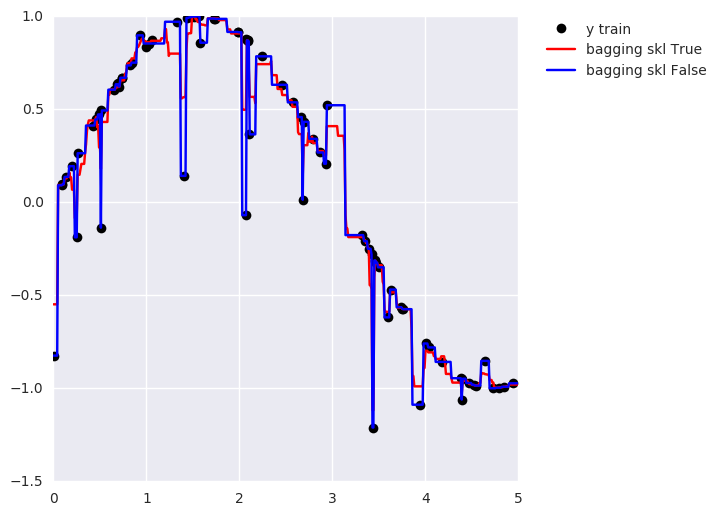

In [30]:
fig = plt.figure(figsize=(6, 6))
plt.plot(X ,y, 'o', c='k', label='y train')
plt.plot(X_test , y_bagskl_true,c='r', label='bagging skl True')
plt.plot(X_test , y_bagskl_false,c='b', label='bagging skl False')
#plt.plot(X_test , y_baghm_true,'.-',c='g', label='bagging hm True')
#plt.plot(X_test , y_baghm_false,'.', c='m', label='bagging hm False')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

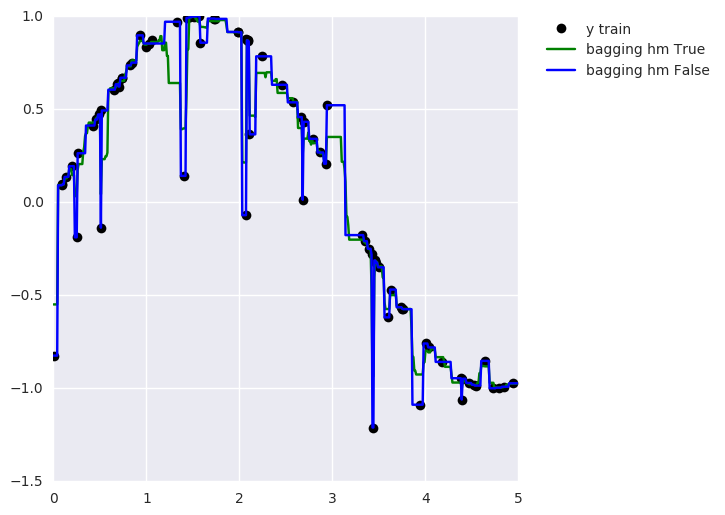

In [31]:
fig = plt.figure(figsize=(6, 6))
plt.plot(X ,y, 'o', c='k', label='y train')
#plt.plot(X_test , y_bagskl_true,c='r', label='bagging skl True')
#plt.plot(X_test , y_bagskl_false,c='k', label='bagging skl False')
plt.plot(X_test , y_baghm_true,c='g', label='bagging hm True')
plt.plot(X_test , y_baghm_false,c='b', label='bagging hm False')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Logiquement, on pourrait penser que, avec l'option sans remise, l'estimateur ne va s'entrainer pas sur les mêmes observations alors que dans le cas du bootstrap, il y a la possibilité qu'une observation apparaisse plusieurs fois dans un échantillon. Par conséquent, avec remise il y a possibilité d'over-fitting. Du moins je l'explique de cette façon, parce qu'avec les graphes ci-dessus, ça n'a pas l'air d'être le cas et notamment on obtient des résultats similaires dans le cas bootstrap=False que ce soit avec l'estimateur bagging de $sklearn$ ou avec celui implémenté dans ce devoir...

# RANDOM FOREST

In [32]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.datasets import load_iris, load_boston, load_diabetes, load_digits
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing

## **Question 6 :**   
Évaluez le score par 7-fold cross-validation des Random Forests sur les datasets boston, diabetes,
iris et digits. Comparez ces performances avec celles d’un SVM linéaire. 
J'ai pris l'option de chercher à optimiser les estimateurs par `GridsearchCV` dans la mesure où je ne vois pas comment comparer 2 estimateurs différents si, à la base, ils n'ont pas été optimisés.

### a- Dataset Boston (regression)

In [33]:
boston = load_boston()
print(boston.data.shape)

(506, 13)


Random forest

In [34]:
parameters = {'n_estimators':[1,50],'max_depth':[10,100]}
rf_rg = RandomForestRegressor()
clf = GridSearchCV(rf_rg, parameters)
X_boston = preprocessing.scale(boston.data)
y_boston = boston.target
clf.fit(X_boston, y_boston)
print(clf.best_params_)


{'n_estimators': 50, 'max_depth': 10}


In [71]:
rf_opt = RandomForestRegressor(n_estimators=50, max_depth=10)
scores_boston = cross_val_score(rf_opt, X_boston, y_boston, cv=7)
print(scores_boston.mean())

0.662806303045


Dans le cas de régresseur, le score est le $R^2$, soit:  
$1-\frac{\sum_{i=0}^{n}(y_{i}-\hat{y_{i}})^2}{\sum_{i=0}^{n}(y_{i}-\bar{y})^2}$ 

SVC avec GridsearchCV

In [36]:
parameters = {'kernel':('linear', 'rbf'), 'C':[0.1, 10]}
svc = svm.SVR()
clf = GridSearchCV(svc, parameters)
clf.fit(X_boston, y_boston)
print(clf.best_params_)

{'kernel': 'linear', 'C': 0.1}


In [37]:
svc_opt = svm.SVR(kernel='linear',C=0.1)
scores_boston_svc = cross_val_score(svc_opt, X_boston, y_boston, cv=7)
print(scores_boston_svc.mean())

0.547927114681


### b- Diabètes (regression)

In [38]:
diabetes = load_diabetes()
X_diabetes = preprocessing.scale(diabetes.data)
y_diabetes = diabetes.target

Random forest

In [39]:
parameters = {'n_estimators':[1,50],'max_depth':[10,100]}
rf_rg = RandomForestRegressor()
clf = GridSearchCV(rf_rg, parameters)
clf.fit(X_diabetes, y_diabetes)
print(clf.best_params_)

{'n_estimators': 50, 'max_depth': 10}


In [72]:
rf_rg = RandomForestRegressor(n_estimators=50, max_depth=10)
scores_diabetes = cross_val_score(rf_rg, X_diabetes, y_diabetes, cv=7)
print(scores_diabetes.mean())


0.411660904065


SVC

In [41]:
parameters = {'kernel':('linear', 'rbf'), 'C':[0.1, 10]}
svc = svm.SVR()
clf = GridSearchCV(svc, parameters)
clf.fit(X_diabetes, y_diabetes)
print(clf.best_params_)

{'kernel': 'linear', 'C': 10}


In [42]:
svc = svm.SVR(kernel='linear',C=10)
scores_diabetes_svc = cross_val_score(svc, X_diabetes, y_diabetes, cv=7)
print(scores_diabetes_svc.mean())

0.467961381009


### c- Iris (classification)

In [43]:
iris = load_iris()
X_iris = preprocessing.scale(iris.data)
y_iris = iris.target

Random forest

In [44]:
parameters = {'n_estimators':[1,50],'max_depth':[10,100]}
rf = RandomForestClassifier()
clf = GridSearchCV(rf, parameters)
clf.fit(X_iris, y_iris)
print(clf.best_params_)

{'n_estimators': 50, 'max_depth': 10}


In [45]:
rf = RandomForestClassifier(n_estimators=50, max_depth=10)

In [46]:
scores_iris = cross_val_score(rf, X_iris, y_iris, cv=7)
print(scores_iris.mean())

0.946428571429


Dans le cadre de la classification, le score est donné par la moyenne des indicatrices telles que le label prédit soit égal au label réel.

SVC

In [47]:
from sklearn.svm import SVC

In [48]:
parameters = {'kernel':('linear', 'rbf'), 'C':[0.1, 10]}
svc=SVC()
clf = GridSearchCV(svc, parameters)
clf.fit(X_iris, y_iris)
print(clf.best_params_)

{'kernel': 'rbf', 'C': 10}


In [49]:
svc=SVC(kernel='rbf',C=10)
scores_iris_svc = cross_val_score(svc, X_iris, y_iris, cv=7)
print(scores_iris_svc.mean())

0.965986394558


### d- Digits (classification)

In [50]:
digits = load_digits()
X_digits = preprocessing.scale(digits.data)
y_digits = digits.target

Random forest

In [51]:
parameters = {'n_estimators':[1,50],'max_depth':[10,100]}
rf = RandomForestClassifier()
clf = GridSearchCV(rf, parameters)
clf.fit(X_digits,y_digits)
print(clf.best_params_)

{'n_estimators': 50, 'max_depth': 10}


In [73]:
rf = RandomForestClassifier(n_estimators=50, max_depth=10)
scores_digits = cross_val_score(rf, X_digits, y_digits, cv=7)
print(scores_digits.mean())

0.925441022139


SVC

In [53]:
parameters = {'kernel':('linear', 'rbf'), 'C':[0.1, 10]}
svc=SVC()
clf = GridSearchCV(svc, parameters)
clf.fit(X_digits, y_digits)
print(clf.best_params_)

{'kernel': 'rbf', 'C': 10}


In [54]:
svc=SVC(kernel='rbf',C=10)
scores_digits_svc = cross_val_score(svc, X_digits, y_digits, cv=7)
print(scores_digits_svc.mean())

0.954874435632


In [55]:
import pandas as pd

In [74]:
d = {'Random forest':pd.Series([scores_boston.mean(), scores_diabetes.mean(), scores_iris.mean(), 
                                scores_digits.mean()], index=['boston', 'diabetes', 'iris', 'digits']),
     'SVM':pd.Series([scores_boston_svc.mean(),scores_diabetes_svc.mean(),scores_iris_svc.mean(), 
                      scores_digits_svc.mean()], index=['boston', 'diabetes', 'iris', 'digits'])}

df = pd.DataFrame(d)
print(df)

          Random forest       SVM
boston         0.662806  0.547927
diabetes       0.411661  0.467961
iris           0.946429  0.965986
digits         0.925441  0.954874


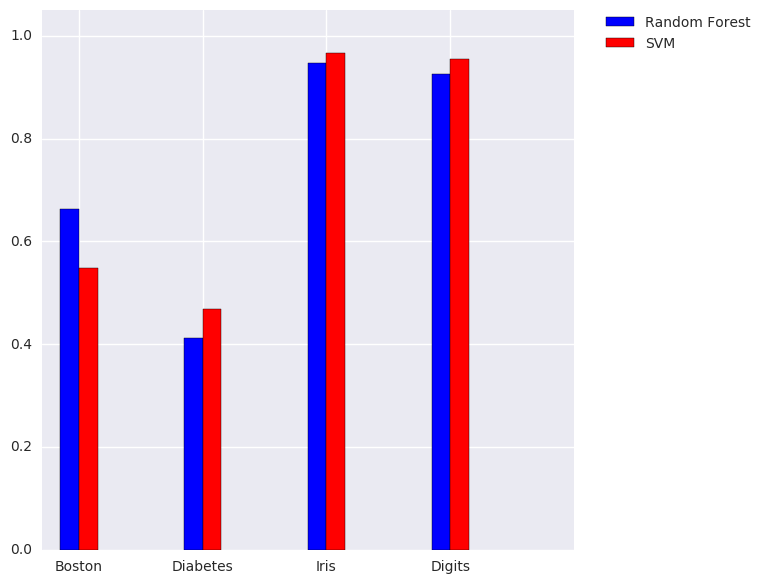

In [75]:
fig = plt.figure(figsize=(6, 6))

ax = fig.add_subplot(111)
ind = np.arange(4)                # the x locations for the groups
width = 0.15
rectsRF = ax.bar(ind, df['Random forest'], width, color='b')
rectsSVM= ax.bar(ind+width, df['SVM'], width, color='r')

ax.set_xlim(-width, len(ind)+width)
ax.set_ylim(0.0, 1.05)
xTickMarks = ['Boston', 'Diabetes', 'Iris', 'Digits']
ax.set_xticks(ind+width)
xtickNames = ax.set_xticklabels(xTickMarks)
ax.legend((rectsRF[0], rectsSVM[0]), ('Random Forest', 'SVM'),bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
plt.show()

**Conclusion:** On a travaillé avec 2 jeux de données en régression (`Boston` et `diabetes`) et 2 jeux de données en classification (`iris` et `digits`). On ne peut évidemment pas comparer les scores de régression avec les scores de classification vu qu'ils utilisent des métriques différentes (et ce ne sont pas les mêmes problèmes).  
En terme de classifieur, on constate dans ces cas précis, que le SVM est meilleur que le random forest. Il faudrait faire plus de tests sur d'autres jeux de données pour savoir si c'est souvent le cas ou non.  
En revanche, pour la régression, il est difficile de conclure.

## **Question 7**:

En utilisant le dataset iris restreint aux deux premières variables explicatives afficher la probabilité
de prédiction des classes. On partira du script suivant et on fera varier le nombre d’arbres aléatoires.  
Dans la question précédente, on a vu que d'après la GridSearch, le nombre optimale d'arbres est de 50. 

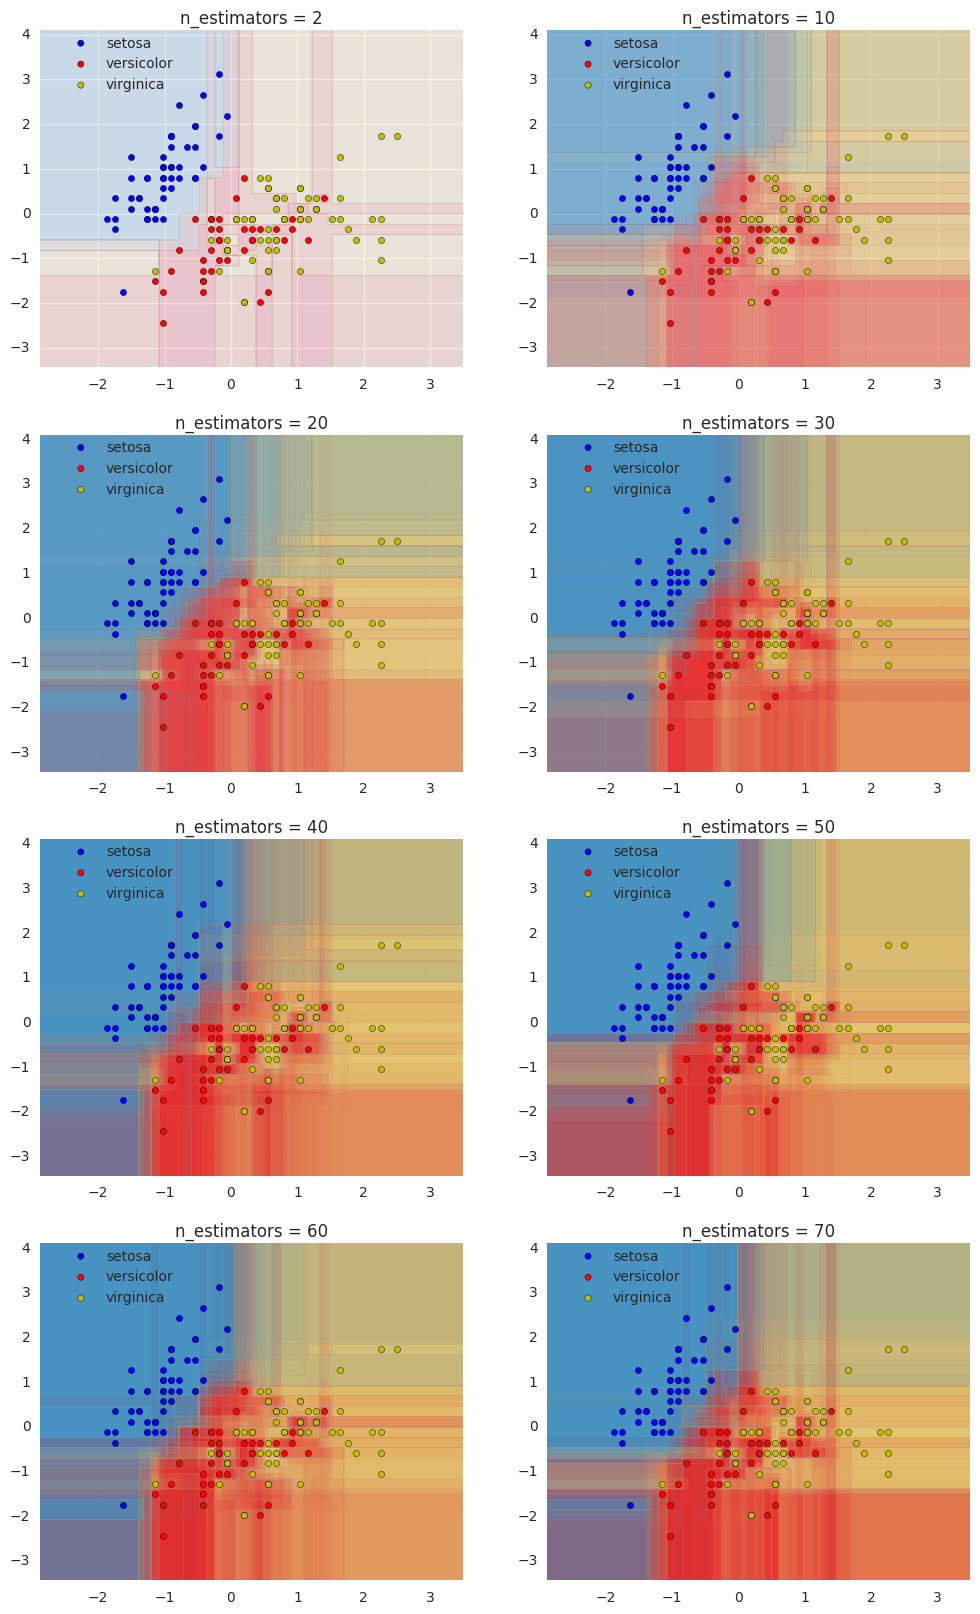

In [58]:
n_estimator = [2,10,20,30,40,50,60,70]
plot_colors = "bry"
plot_step = 0.02
plt.figure(figsize=(12, 20))
# Load data
iris = load_iris()
X_unscaled, y = iris.data[:, :2], iris.target
# Standardize
X = preprocessing.scale(X_unscaled)
# Parameters
j = 1
for el in n_estimator:
    plt.subplot(4, 2, j)
    model = RandomForestClassifier(n_estimators=el)
    clf = model.fit(X, y)
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),np.arange(y_min, y_max, plot_step))
    for tree in model.estimators_:
        Z = tree.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        cs = plt.contourf(xx, yy, Z, alpha=1. / n_estimators, cmap=plt.cm.Paired)
        plt.axis("tight")
    for i, c in zip(range(3), plot_colors):
        idx = np.where(y == i)
        plt.scatter(X[idx, 0], X[idx, 1], c=c, label=iris.target_names[i], cmap=plt.cm.Paired)
        plt.legend(scatterpoints=1,bbox_to_anchor=(0.05, 1), loc=2, borderaxespad=0.)
        plt.title('n_estimators = '+str(el))
    j +=1


**Conclusion:**  
En augmentant le nombre d'estimateurs, on parvient mieux à distinguer les classes car les frontières de décision étant plus nombreuses sont mieux ajustées.

### **Question 8:**    
Comparez les scores par 6-fold cross-validation des Random Forests et des arbres de décisions
pures (obtenus avec DecisionTreeClassifier), sur le dataset iris restreint aux deux premières
variables. On fera varier le paramètre max_depth entre 1 et 30. Mettre en évidence le fait que les
Random Forests permettent de réduire le sur-apprentissage, et ce même pour des arbres profonds.

In [59]:
from sklearn.tree import  DecisionTreeClassifier                            

In [60]:
score_rf = []
score_dt = []
max_depth = 30
iris = load_iris()
X_unscaled, y = iris.data[:, :2], iris.target
# Standardize
X = preprocessing.scale(X_unscaled)
for i in range(1, max_depth+1):
    rf = RandomForestClassifier(max_depth=i)
    sc_rf = cross_val_score(rf, X, y,cv=6)
    score_rf.append(sc_rf.mean()) 
    dt = DecisionTreeClassifier(max_depth=i)
    sc_dt = cross_val_score(dt, X, y,cv=6)
    score_dt.append(sc_dt.mean())
print('score de la random forest')
print(score_rf)
print(' ')
print('score du decision tree')
print(score_dt)
    

score de la random forest
[0.65432098765432101, 0.78163580246913578, 0.78858024691358031, 0.72608024691358031, 0.76003086419753096, 0.70524691358024694, 0.71913580246913578, 0.71913580246913578, 0.7206790123456791, 0.66589506172839508, 0.6875, 0.68518518518518523, 0.69984567901234573, 0.66820987654320974, 0.68672839506172834, 0.68055555555555547, 0.67129629629629628, 0.67361111111111105, 0.73225308641975317, 0.68055555555555547, 0.69984567901234573, 0.71990740740740744, 0.68672839506172834, 0.68055555555555569, 0.73379629629629639, 0.69984567901234562, 0.69367283950617287, 0.67361111111111116, 0.72222222222222221, 0.6929012345679012]
 
score du decision tree
[0.62731481481481477, 0.73456790123456794, 0.75462962962962976, 0.76774691358024683, 0.7538580246913581, 0.73919753086419748, 0.71836419753086422, 0.69907407407407407, 0.68672839506172834, 0.69212962962962965, 0.70679012345679026, 0.69984567901234573, 0.68672839506172834, 0.7006172839506174, 0.7006172839506174, 0.7006172839506174, 

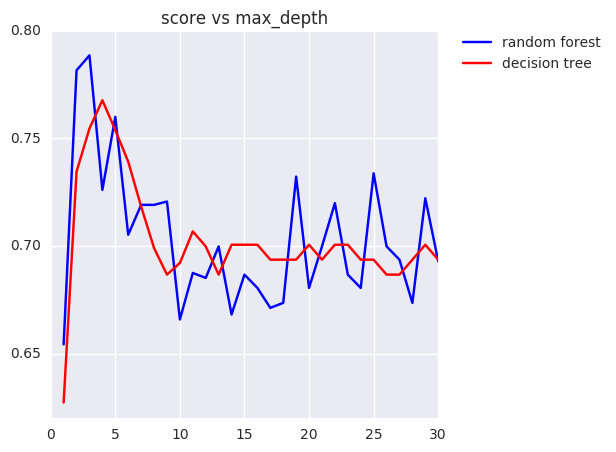

In [61]:
fig = plt.figure(figsize=(5, 5))
x_scoredt= np.arange(1.0, 31.0, 1.0)
plt.plot(x_scoredt, score_rf, c='b', label ='random forest')
plt.plot(x_scoredt, score_dt, c='r', label ='decision tree')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('score vs max_depth')

**Conclusion**  
On constate que lorsque la profondeur de l'arbre augmente (max_depth > 7), en ce qui concerne le decision tree, sa performance se stabilise autour d'une valeur : il y a alors sur-apprentissage. Ce qui n'est pas le cas pour le random forest où les fluctuations restent importantes.

## BOOSTING

### **Question 9:**

D'après la référence http://statweb.stanford.edu/~jhf/ftp/boost.pdf :  
On cherche à minimiser le risque $R_{exp}(f)=\mathbb{E}(exp(-Yf(x))$: 
  
On peut décomposer $\mathbb{E}(exp(-Yf(x))$ de la façon suivante d'après les propriétés de l'espérance conditionnelle:  
$\mathbb{E}(exp(-Yf(x)) = \mathbb{P}(Y=1|x) exp(−f(x))+\mathbb{P}(Y=-1|x)exp(f(x))$  
  
Pour minimiser le risque, il faut différencier par rapport à f(x) et annuler la quantité obtenue:  
$\frac{\partial\mathbb{E}[exp(−Y f (x))|x]}{\partial f(x)} = -\mathbb{P}(Y=1|x)exp(−f(x))+\mathbb{P}(Y=-1|x)exp(f(x))$  
  
$\frac{\partial\mathbb{E}[exp(−Y f (x))|x]}{\partial f} = 0$ en $f^*$   
  
En notant $\eta(x)=\mathbb{P}(Y=1|x)$ , on a donc $\eta(x)exp(−f^*(x))= (1-\eta(x))exp(f^*(x))$  
  
soit $\frac{\eta(x)}{1-\eta(x)} = exp(2f^*(x))$  
  
Par conséquent:  
$f^*(x) = \frac{1}{2}log\frac{\eta(x)}{1-\eta(x)}$

### **Question 10:**

Le classifieur de Bayes est la solution du problème de minimisation du risque théorique sous perte binaire.
En supposant $\phi_{0}<\phi$ où $\phi$ est une fonction convexe alors la fonction minimisant $R_{\phi 0}$ est la même que celle minimisant $R_{\phi=exp}$. Dans ce casles deux classifieurs de Bayes associés à chacune des deux fonctions de coût $R$ sont les mêmes.

## **ADABOOST**

### **Question 11:**

Dans la boucle de l'algorithme Adaboost, on s'intéresse au classifieur $h_{m}$.
Sachant que :  
$\mathbb{P}_{w^{m-1}}(Y \neq \hat{h}_{m}(X)) =\sum_{i=1}^{n}(w_{i}^{m-1}\mathbb{1}_{Y_{i} \neq \hat{h}_{m}(X_{i})})$  
$\mathbb{P}_{w^{m-1}}(Y = \hat{h}_{m}(X)) =\sum_{i=1}^{n}(w_{i}^{m-1}\mathbb{1}_{Y_{i} = \hat{h}_{m}(X_{i})})$  
on veut minimiser le risque $R_{exp}$ associé à $h_{m}$.  
  
En reprenant la question 9 du devoir on a démontré que le minimiseur de:  
$\mathbb{E}(exp(-Yf(x)) = P(Y=1|x) exp(−f(x))+P(Y=-1|x)exp(f(x))$  
est $f^*(x) = \frac{1}{2}log\frac{\eta(x)}{1-\eta(x)}$ avec $\eta(x)=P(Y=1|x)$.  
On reprend le même principe de démonstration:  
$\mathbb{E}(exp(-Yh_m(x)) = \mathbb{P}(Y=1|x)exp(−h_m(x))+\mathbb{P}(Y=-1|x)exp(h_m(x))$  
or $\mathbb{P}(Y=1|x) = \mathbb{P}_w(Y=h_m(x))$ et $\mathbb{P}(Y\neq1|x) = \mathbb{P}_w(Y\neq h_m(x))$   
Donc le minimiseur du risque exp. dans ce cas est :
$\frac{1}{2}log\frac{\mathbb{P_w}(Y=h_m(x))}{1-\mathbb{P_w}(Y=h_m(x))}$  soit
$\frac{1}{2}log\frac{\mathbb{P_w}(Y=h_m(x))}{\mathbb{P}_w(Y\neq h_m(x))}$ 

### **Question 12:**

On initialise $w^{0} = \omega^{0} = (\frac{1}{n},...,\frac{1}{n})$ et $\hat{F}_{0}$.  
On suppose que $\omega_i^m  \propto \omega_i^{m-1} . exp(-c_m^{*} Y_i.\hat{h_m}(X_i))$  
avec $c_m^{*} = argmin_{c\in \mathbb{R}}\mathbb{E_{n}} [exp(−Y(\hat{F}_{m-1}(X) + c · \hat{h}_{m}(X)))]$  
et d'après l'énoncé:   
$w_{i}^{m}  \propto w_{i}^{m-1} . exp(2c_m \mathbb{1}_{Y_i \neq \hat{h}_{m}(X_i)})$  
  
avec $c_{m}= \frac{1}{2}log(\frac{ \mathbb{P}_{w^{m-1}}(Y = \hat{h}_m (X))}{\mathbb{P}_{w^{m-1}}(Y \neq \hat{h}_m (X))})$  
  
On va montrer l'égalité de $w^{m} = \omega^{m}$ $(1)$ par récurrence.
$(1)$ est vraie au rang 0
On suppose $(1)$ vraie au rang $m-1$  
Dans un premier temps on va montrer que $c_m^*$=$c_m$:  
minimiser $\mathbb{E}_{n}[exp(-Y(\hat{F}_{m-1}(X)+c_m.\hat{h}_{m}(X)))]$ pour $c\in \mathbb{R}$ revient à chercher le minimiseur de:  
$\mathbb{E}_{\omega^{m-1}}[exp(-Y c_m.\hat{h}_{m}(X))]$ $(1)$ avec $\omega_{i}^{m-1}\propto exp(-Y\hat{F}_{m-1}(X_i))$  
  
On peut réécrire $(1)$ sous la forme:  
$\frac{1}{n}  \sum_{i=1}^{n}  [\omega_i^{m-1} exp(−Y_{i}(c_m·\hat{h}_m (X_i)))]$ $(2)$    
On peut décomposer $(2)$:  
$\frac{1}{n}  \sum_{i:y_{i} \hat{h}_{m} (x_{i} )=+1}^{n}  [\omega_i^{m-1} exp(−Y_{i}c_m·\hat{h}_m (X_i))] +$
$\frac{1}{n}  \sum_{i:y_{i} \hat{h}_{m} (x_{i} )=-1}^{n}  [\omega_i^{m-1} exp(−Y_{i}c_m·\hat{h}_m (X_i))]$
  
On peut simplifier la relation précédente:  
$\frac{1}{n}exp(-c_m)\sum_{i:y_{i} \hat{h}_{m} (x_{i} )=+1}^{n}  \omega_i^{m-1} +$
$\frac{1}{n}exp(c_m) \sum_{i:y_{i} \hat{h}_{m} (x_{i} )=-1}^{n}  \omega_i^{m-1}$ $(3)$   
Comme pour la question 9, on va minimiser $(3)$ en la différenciant par rapport à $c$, ce qui donne :
$ -\frac{1}{n}exp(-c_m^*)\sum_{i:y_{i} \hat{h}_{m} (x_{i} )=+1} \omega_i^{m-1}+\frac{1}{n}exp(c_m^*)  \sum_{i:y_{i} \hat{h}_{m} (x_{i} )=-1} \omega_i^{m-1}=0$  
d'où:  
$exp(2c_m^*) = \frac{\frac{1}{n} \sum_{i:y_{i} \hat{h}_{m} (x_{i} )=+1} \omega_i^{m-1}}{\frac{1}{n}  \sum_{i:y_{i} \hat{h}_{m} (x_{i} )=-1}  \omega_i^{m-1}}$  
En posant $\mathbb{P}_{\omega^{m-1}}(Y = \hat{h}_m (X))=\frac{1}{n} \sum_{i:y_{i} \hat{h}_{m} (x_{i} )=+1} \omega_i^{m-1}$  
et  
$\mathbb{P}_{\omega^{m-1}}(Y \neq \hat{h}_m (X))=\frac{1}{n} \sum_{i:y_{i} \hat{h}_{m} (x_{i} )=-1} \omega_i^{m-1}$  
on obtient finalement:  
$c_m^*= \frac{1}{2}log(\frac{ \mathbb{P}_{\omega^{m-1}}(Y = \hat{h}_m (X))}{\mathbb{P}_{\omega^{m-1}}(Y \neq \hat{h}_m (X))})$  
Bien que les poids $w$ et $\omega$ soient différents, $\mathbb{P}_{\omega^{m-1}}=\mathbb{P}_{w^{m-1}}$ donc:  
$c_m = c_m^*$  
  
Comme au rang $m-1$, on a supposé que $w_{m-1} = \omega_{m-1}$ et qu'on a montré que $c_m = c_m^* =c$, il ne nous reste plus qu'à montrer que :  
$exp(-c Y_i.\hat{h_m}(X_i))=exp(2c \mathbb{1}_{Y_i \neq \hat{h}_{m}(X_i)})$  
soit $-Y_i.\hat{h_m}(X_i)=2.\mathbb{1}_{Y_i \neq \hat{h}_{m}(X_i)}$
ce qui est le cas.  
Vrai aussi au rang $m$ donc vrai pour tous les rangs.

### **Question 13:**

Mettre en œuvre AdaBoost avec des arbres de profondeur 1, puis 2, puis 10, sur le jeu de données
`digits`. On calculera notamment la précision obtenue par 6-fold cross-validation. 

In [62]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

On fait varier la profondeur de l'arbre de décision. Pour le nombre d'estimateurs, on garde la valeur par défaut de $skleanr$, à savoir n_estimators = 50.

In [63]:
depth = [1,2,10]
scores_ada = []
scores_ada_tot =np.zeros((3,6))
j = 0
for i in depth:
    tree = DecisionTreeClassifier(max_depth=i)
    ada = AdaBoostClassifier(base_estimator=tree)
    ada.fit(X_digits, y_digits)
    sc = cross_val_score(ada, X_digits, y_digits, cv=6)
    scores_ada_tot[j,:] = sc
    scores_ada.append(sc.mean())
    j += 1
print(scores_ada_tot)

[[ 0.28618421  0.28145695  0.26666667  0.27852349  0.20538721  0.26689189]
 [ 0.47368421  0.59602649  0.57333333  0.63758389  0.67676768  0.59797297]
 [ 0.95065789  0.95695364  0.95666667  0.97315436  0.97643098  0.92905405]]


In [64]:
print(scores_ada)

[0.26418506967455829, 0.59256142938066236, 0.95715293278145885]


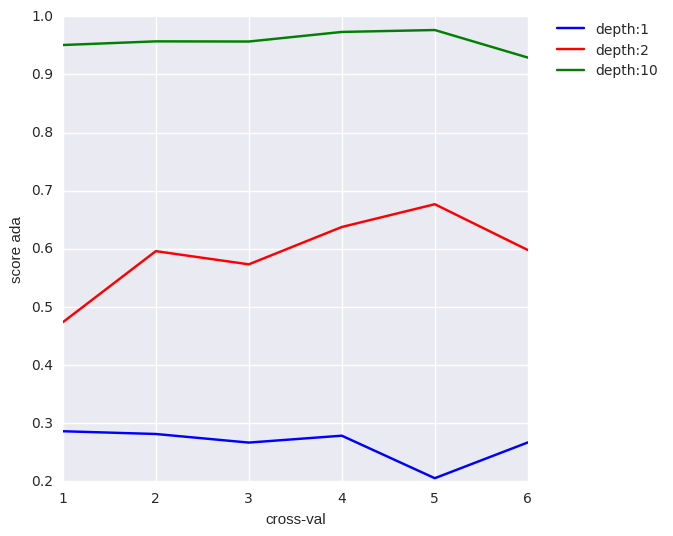

In [65]:
fig = plt.figure(figsize=(6, 6))
x_ada = np.arange(1.0, 7.0, 1.0)
plt.plot(x_ada ,scores_ada_tot[0,:], c='b', label='depth:1')
plt.plot(x_ada ,scores_ada_tot[1,:],c='r', label='depth:2')
plt.plot(x_ada ,scores_ada_tot[2,:],c='g', label='depth:10')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('cross-val')
plt.ylabel('score ada')

**Conclusion :**   
La profondeur d'arbre joue un role important dans le score obtenu. Plus elle est élevée, meilleur semble être le score. 

### **Question 14:**  
Appliquer AdaBoost sur les données `digits` découpées en deux échantillons : apprentissage (75%)
et test (25%). Tracer les erreurs (0/1) d’apprentissage et de test en fonction du nombre d’itérations. 
http://scikit-learn.org/stable/auto_examples/ensemble/plot_adaboost_hastie_10_2.html#sphx-glr-auto-examples-ensemble-plot-adaboost-hastie-10-2-py  
On va utiliser la métrique `zero_one_loss` de $sklearn$ qui permet de calculer la proportion d'erreurs de classification, plus le score est proche de 0, meilleure est la classification.  
D'après la question $6$, on a vu que la profondeur optimale des arbres est de 50 pour un nombre d'estimateurs de 100 avec le random forest. On voit déjà avec une profondeur de 10 et 50 estimateurs pour le adaboost, on a un meilleur score qu'avec le random forest.

In [66]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import zero_one_loss

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X_digits, y_digits, test_size=0.25, random_state=42)

In [68]:
tree = DecisionTreeClassifier(max_depth=100)
loss_ada_test = []
loss_ada_train = []
loss_rf_test = []
loss_rf_train = []
for i in range(1,100):
    ada = AdaBoostClassifier(base_estimator=tree, n_estimators = i)
    ada.fit(X_train,y_train)
    y_pred_train = ada.predict(X_train)
    y_pred_test = ada.predict(X_test)
    loss_ada_test.append(zero_one_loss(y_test, y_pred_test))
    loss_ada_train.append(zero_one_loss(y_train, y_pred_train))
    rf = RandomForestClassifier(n_estimators=i, max_depth=100)
    rf.fit(X_train,y_train)
    y_predrf_train = rf.predict(X_train)
    y_predrf_test = rf.predict(X_test)
    loss_rf_test.append(zero_one_loss(y_test, y_predrf_test))
    loss_rf_train.append(zero_one_loss(y_train, y_predrf_train))

    



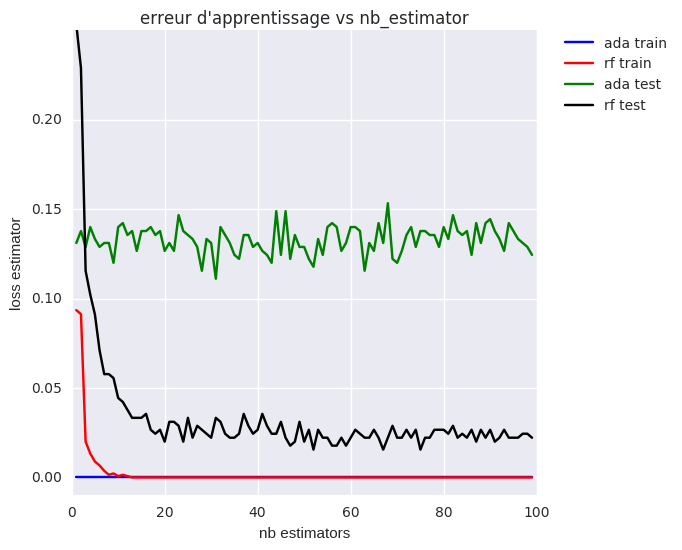

In [69]:
fig = plt.figure(figsize=(6, 6))
x_loss = np.arange(1.0, 100, 1.0)
plt.plot(x_loss, loss_ada_train, c='b', label='ada train')
plt.plot(x_loss, loss_rf_train, c='r', label='rf train')
plt.plot(x_loss, loss_ada_test, c='g', label='ada test')
plt.plot(x_loss, loss_rf_test, c='k', label='rf test')
plt.ylim([-0.01,0.25])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('nb estimators')
plt.ylabel('loss estimator')
plt.title('erreur d\'apprentissage vs nb_estimator')

Ce qui est étonnant c'est que le score ne s'améliore pas dans le cas du adaboost sur le set de test...?

### **Question 15 **  
On va faire varier la profondeur des arbres pour voir s'il y a une différence.

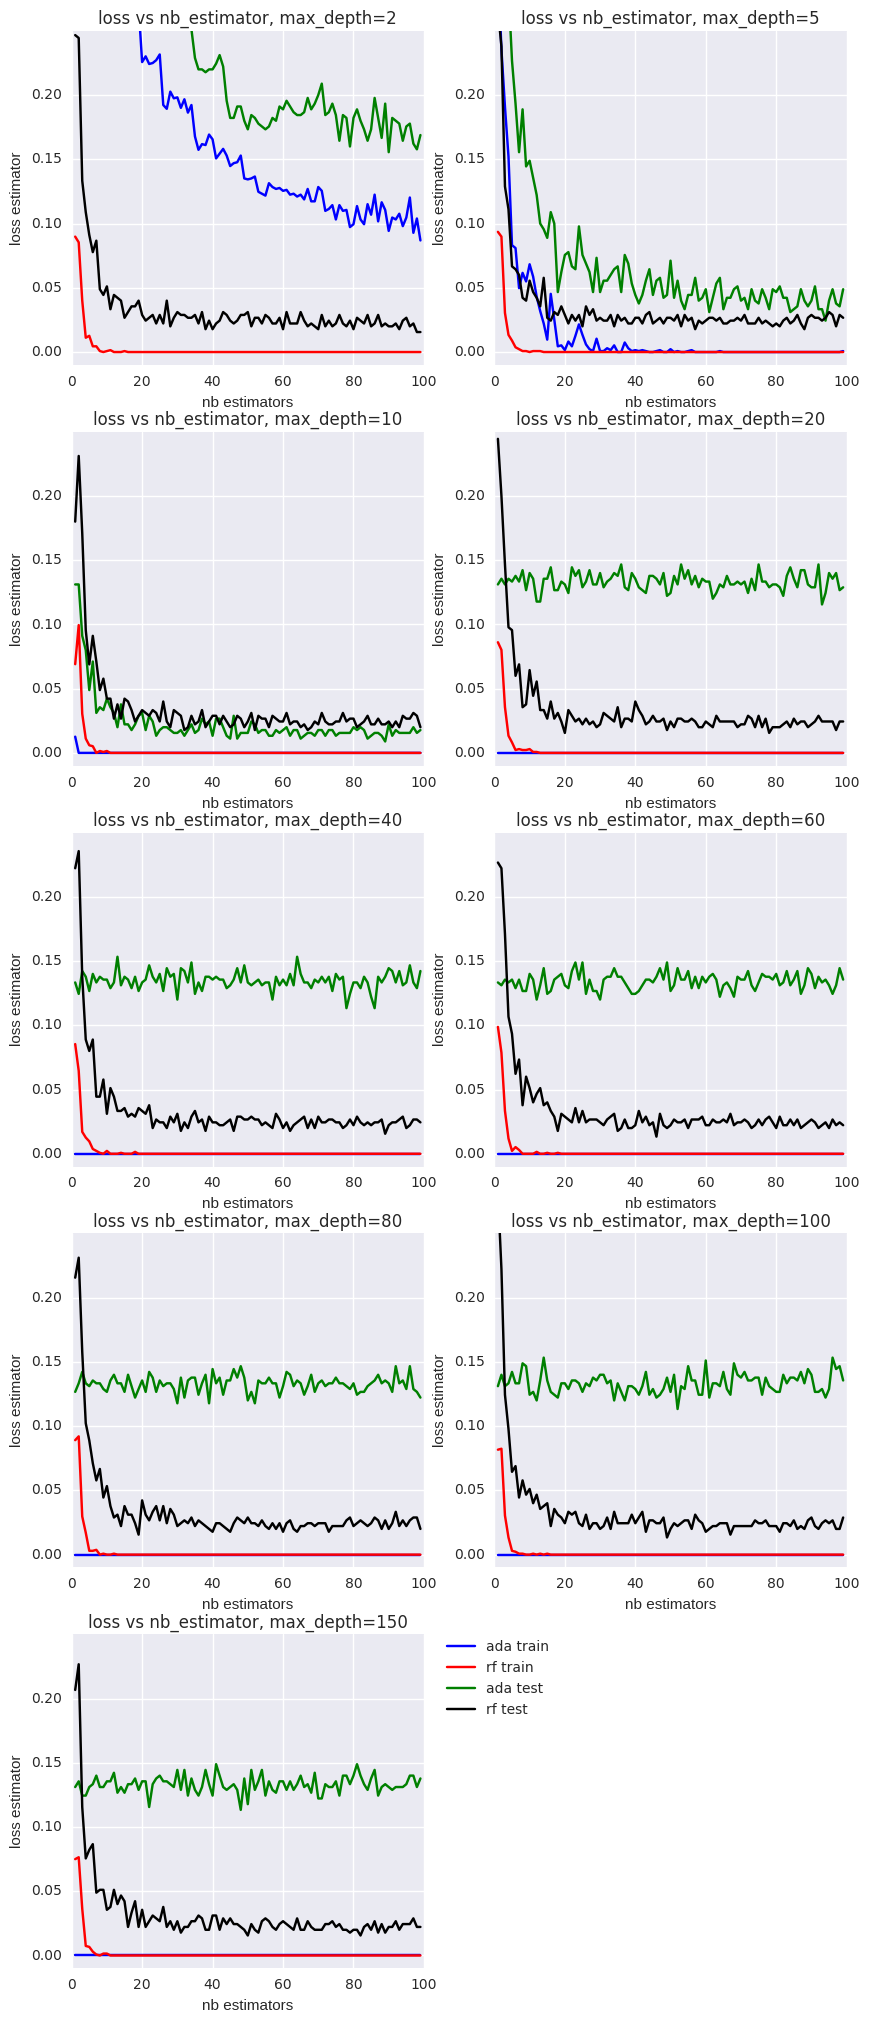

In [70]:
max_d = [2,5,10,20,40,60,80,100,150]
x_loss = np.arange(1.0, 100, 1.0)
plt.figure(figsize=(10, 25))

j = 1
for el in max_d:
    plt.subplot(5, 2, j)
    tree = DecisionTreeClassifier(max_depth=el)
    loss_ada_test = []
    loss_ada_train = []
    loss_rf_test = []
    loss_rf_train = []
    for i in range(1,100):
        ada = AdaBoostClassifier(base_estimator=tree, n_estimators = i)
        ada.fit(X_train,y_train)
        y_pred_train = ada.predict(X_train)
        y_pred_test = ada.predict(X_test)
        loss_ada_test.append(zero_one_loss(y_test, y_pred_test))
        loss_ada_train.append(zero_one_loss(y_train, y_pred_train))
        rf = RandomForestClassifier(n_estimators=i, max_depth=100)
        rf.fit(X_train,y_train)
        y_predrf_train = rf.predict(X_train)
        y_predrf_test = rf.predict(X_test)
        loss_rf_test.append(zero_one_loss(y_test, y_predrf_test))
        loss_rf_train.append(zero_one_loss(y_train, y_predrf_train))
    plt.plot(x_loss, loss_ada_train, c='b', label='ada train')
    plt.plot(x_loss, loss_rf_train, c='r', label='rf train')
    plt.plot(x_loss, loss_ada_test, c='g', label='ada test')
    plt.plot(x_loss, loss_rf_test, c='k', label='rf test')
    plt.ylim([-0.01,0.25])
    plt.xlabel('nb estimators')
    plt.ylabel('loss estimator')
    plt.title('loss vs nb_estimator, max_depth='+str(el))
    j += 1
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)   
    
    

On voit qu'à partir d'une certaine profondeur d'arbres le score d'adaboost sur le test ne s'améliore plus.